In [ ]:
"""
https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
"""
# !pip show torch
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.9.0+cpu.html
# !pip install torch==1.0.1.post2 torch-cluster==1.2.4 torch-geometric==1.0.3 torch-scatter==1.1.2 torch-sparse==0.2.4 torch-spline-conv==1.0.6 matplotlib==3.1.0 
# !pip install torch==1.8.2+cpu torchvision==0.9.2+cpu torchaudio===0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
# !pip uninstall -y torch-scatter
# !pip uninstall -y torch-sparse
# !pip uninstall -y torch-cluster


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

!pip install -q torch-geometric
!pip install neuralogic

# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.8.0+cpu.html

In [ ]:
!pip show torch
print()
!pip show torch-geometric

Name: torch
Version: 1.10.0+cu111
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai

Name: torch-geometric
Version: 2.0.3
Summary: Graph Neural Network Library for PyTorch
Home-page: https://github.com/pyg-team/pytorch_geometric
Author: Matthias Fey
Author-email: matthias.fey@tu-dortmund.de
License: UNKNOWN
Location: /usr/local/lib/python3.7/dist-packages
Requires: networkx, pyparsing, requests, yacs, PyYAML, tqdm, numpy, scipy, scikit-learn, googledrivedownloader, rdflib, jinja2, pandas
Required-by: 


In [ ]:
!pip install addict nltk PyYAML names inflect networkx pandas tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

def path_to(name):
  return "/content/gdrive/MyDrive/bakalarka/data/clutrr/" + name



Mounted at /content/gdrive


In [ ]:
import os
import json
import glob
print(os.listdir(path_to("")))

['data_7c5b0e70', 'relations_store.yaml', 'data_089907f8']


## CLUTRR - experiments

#### Data preprocessing

In [ ]:
from addict import Dict

_test_paths = [
    "data_089907f8/1.2_test.csv",
    "data_089907f8/1.3_test.csv",
    "data_089907f8/1.4_test.csv",
    "data_089907f8/1.5_test.csv",
    "data_089907f8/1.6_test.csv",
    "data_089907f8/1.7_test.csv",
    "data_089907f8/1.8_test.csv",
    "data_089907f8/1.9_test.csv",
    "data_089907f8/1.10_test.csv",
]
config = Dict(
    {
      'train_path': "data_089907f8/1.2,1.3_train.csv",
      'test_paths': _test_paths,
      'model': 'gcn',
      'epochs': 40,
      'learning_rate': 0.001,
      'batch_size': 100,
      'embedding_size': 100,
      'edge_embedding_size': 20,
      'hidden_size': 100,
      'nb_filters': 100,
      'nb_heads': 3,
      'nb_rounds': 3,
      'nb_highway': 2,
      'seed': 0,
      'evaluate_every': 5,
      'v2': False,
      'is_predicate': False,
    }
)

In [ ]:
import yaml

with open(path_to("relations_store.yaml"), 'r') as f:
    relations_dict = yaml.safe_load(f)


In [ ]:
# relations

In [ ]:
import csv
import json

from collections import OrderedDict

from typing import List, Tuple, Any, Optional, Dict

Fact = Tuple[str, str, str]
Story = List[Fact]


class Instance:
    def __init__(self,
                 story: Story,
                 target: Fact,
                 nb_nodes: Optional[int] = None):
        self._story = story
        self._target = target
        self._nb_nodes = nb_nodes

    @property
    def story(self) -> Story:
        return self._story

    @property
    def target(self) -> Fact:
        return self._target

    @property
    def nb_nodes(self) -> Optional[int]:
        return self._nb_nodes

    def __str__(self) -> str:
        return f'{self.story}\t{self.target}'


class Data:
    def __init__(self,
                 train_path,
                 test_paths: Optional[List[str]] = None):


        self.relation_to_predicate = {r['rel']: k for k, v in relations_dict.items()
                                      for _, r in v.items() if k != 'no-relation'}

        self.relation_lst = sorted({r for r in self.relation_to_predicate.keys()})
        self.predicate_lst = sorted({p for p in self.relation_to_predicate.values()})

        self.predicate_to_relations = {p: [r for r in self.relation_lst if p == self.relation_to_predicate[r]]
                                       for p in self.predicate_lst}

        self._train_instances = Data.parse(train_path)
        entity_set = {s for i in self.train for (s, _, _) in i.story} | {o for i in self.train for (_, _, o) in i.story}

        self._test_instances = OrderedDict()
        for test_path in (test_paths if test_paths is not None else []):
            i_lst = self._test_instances[test_path] = Data.parse(test_path)
            entity_set |= {s for i in i_lst for (s, _, _) in i.story} | {o for i in i_lst for (_, _, o) in i.story}

        self.entity_lst = sorted(entity_set)

        for instance in self.train:
            for s, r, o in instance.story:
                assert s in self.entity_lst and o in self.entity_lst
                assert r in self.relation_lst

    @property
    def train(self) -> List[Instance]:
        return self._train_instances[:1000]

    @property
    def test(self) -> Dict[str, List[Instance]]:
        return self._test_instances

    @staticmethod
    def _to_obj(s: str) -> Any:
        return json.loads(s.replace(")", "]").replace("(", "[").replace("'", "\""))

    @staticmethod
    def parse(path: str) -> List[Instance]:
        res = []
        with open(path, newline='') as f:
            reader = csv.reader(f)
            for row in reader:
                _id, _, _, query, _, target, _, _, _, _, _, story_edges, edge_types, _, genders, _, tmp, _ = row
                if len(_id) > 0:
                    nb_nodes = int(tmp[tmp.rfind(":") + 2:-1]) + 1
                    id_to_name = {i: name.split(':')[0] for i, name in enumerate(genders.split(','))}
                    _story, _edge, _query = Data._to_obj(story_edges), Data._to_obj(edge_types), Data._to_obj(query)
                    triples = [(id_to_name[s_id], p, id_to_name[o_id]) for (s_id, o_id), p in zip(_story, _edge)]
                    target = (_query[0], target, _query[1])
                    instance = Instance(triples, target, nb_nodes=nb_nodes)
                    res += [instance]
        return res


In [ ]:
train_path = path_to(config.train_path)
test_paths = [path_to(tf) for tf in config.test_paths]


data = Data(train_path, test_paths)
entity_lst, relation_lst = data.entity_lst, data.relation_lst
predicate_lst = data.predicate_lst

relation_to_predicate = data.relation_to_predicate

test_relation_lst = ["aunt", "brother", "daughter", "daughter-in-law", "father", "father-in-law", "granddaughter",
                      "grandfather", "grandmother", "grandson", "mother", "mother-in-law", "nephew", "niece",
                      "sister", "son", "son-in-law", "uncle"]

test_predicate_lst = sorted({relation_to_predicate[r] for r in test_relation_lst})

relation_to_idx = {r: i for i, r in enumerate(relation_lst)}
test_relation_to_idx = {r: i for i, r in enumerate(test_relation_lst)}

predicate_to_idx = {p: i for i, p in enumerate(predicate_lst)}
test_predicate_to_idx = {p: i for i, p in enumerate(test_predicate_lst)}

nb_nodes = len(entity_lst)
nb_edge_types = len(relation_lst)
nb_targets = len(test_relation_lst)

# if is_predicate is True:
#     nb_edge_types = len(predicate_lst)
#     nb_targets = len(test_predicate_lst)



In [ ]:

len(data.train)

1000

In [ ]:
print(len(data.test))
data.test.keys()

9


odict_keys(['/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.2_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.3_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.4_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.5_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.6_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.7_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.8_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.9_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.10_test.csv'])

In [ ]:
import numpy as np
import torch
from torch import nn, Tensor
from torch_geometric.data import Data as GeometricData, Batch

from typing import Dict, List, Tuple, Optional


def make_batches(size: int, batch_size: int) -> List[Tuple[int, int]]:
    nb_batch = int(np.ceil(size / float(batch_size)))
    res = [(i * batch_size, min(size, (i + 1) * batch_size)) for i in range(0, nb_batch)]
    return res


def to_data(instance: Instance,
            relation_to_idx: Dict[str, int],
            test_relation_to_idx: Dict[str, int],
            nb_entities: int,

            is_predicate: bool,
            predicate_to_idx: Dict[str, int],
            relation_to_predicate: Dict[str, str],
            test_predicate_to_idx: Dict[str, int],

            device: Optional[torch.device] = None) -> Tuple[GeometricData, Tuple[int, int]]:
    entity_lst = sorted({x for t in instance.story for x in {t[0], t[2]}})
    entity_to_idx = {e: i for i, e in enumerate(entity_lst)}

    x = torch.arange(nb_entities, device=device).view(-1, 1)

    edge_list = [(entity_to_idx[s], entity_to_idx[o]) for (s, _, o) in instance.story]
    edge_index = torch.tensor(list(zip(*edge_list)), dtype=torch.long, device=device)

    if is_predicate is True:
        edge_types = [predicate_to_idx[relation_to_predicate[p]] for (_, p, _) in instance.story]
        y = torch.tensor([test_predicate_to_idx[relation_to_predicate[instance.target[1]]]], device=device)
    else:
        edge_types = [relation_to_idx[p] for (_, p, _) in instance.story]
        y = torch.tensor([test_relation_to_idx[instance.target[1]]], device=device)

    edge_attr = torch.tensor(edge_types, dtype=torch.long, device=device).view(-1, 1)

    res = GeometricData(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

    target_pair = (entity_to_idx[instance.target[0]], entity_to_idx[instance.target[2]])
    return res, target_pair


def to_batches(instances: List[Instance],
               batch_size: int,
               relation_to_idx: Dict[str, int],
               test_relation_to_idx: Dict[str, int],

               is_predicate: bool,
               predicate_to_idx: Dict[str, int],
               relation_to_predicate: Dict[str, str],
               test_predicate_to_idx: Dict[str, int],

               device: Optional[torch.device] = None) -> List[Tuple[Batch, List[int], Tensor, List[Instance]]]:
    nb_instances, res = len(instances), []
    batches = make_batches(nb_instances, batch_size)

    for batch_start, batch_end in batches:
        batch_instances = instances[batch_start:batch_end]
        max_nb_entities = max(i.nb_nodes for i in batch_instances)
        this_batch_size = len(batch_instances)

        batch_pairs = [
            to_data(i, relation_to_idx, test_relation_to_idx, max_nb_entities,
                    is_predicate, predicate_to_idx, relation_to_predicate, test_predicate_to_idx, device=device)
            for i in batch_instances
        ]

        batch_data: List[GeometricData] = [d for d, _ in batch_pairs]
        batch_targets: List[List[int]] = [[p[0], p[1]] for _, p in batch_pairs]

        max_node = max(i + 1 for b in batch_data for i in b.x[:, 0].cpu().numpy())

        batch = Batch.from_data_list(batch_data)
        slices = [max_node for _ in batch_data]

        targets = torch.tensor(batch_targets, dtype=torch.long, device=device).view(this_batch_size, 1, 2)

        res += [(batch, slices, targets, batch_instances)]
    return res


def to_flat_data(instances: List[Instance],
                batch_size: int,
                relation_to_idx: Dict[str, int],
                test_relation_to_idx: Dict[str, int],

                is_predicate: bool,
                predicate_to_idx: Dict[str, int],
                relation_to_predicate: Dict[str, str],
                test_predicate_to_idx: Dict[str, int],

                device: Optional[torch.device] = None) -> Tuple[List[GeometricData], List[Tuple[int, int]]]:
    res = []
    nb_entities = max(i.nb_nodes for i in instances)
    nb_instances = len(instances)
    targets, data_lst = [], []

    for instance in instances:
        data, target_pair = to_data(instance, relation_to_idx, test_relation_to_idx,
                                    nb_entities, is_predicate, predicate_to_idx,
                                    relation_to_predicate, test_predicate_to_idx,
                                    device=device)
        data_lst.append(data)
        targets.append(list(target_pair))
    # targets = torch.tensor(targets, dtype=torch.long, device=device).view(nb_instances, 1, 2)
    return data_lst, targets
    




In [ ]:

np.random.seed(config.seed)
torch.manual_seed(config.seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)


Device: cpu


In [ ]:
nb_instances = len(data.train)
batches = to_batches(data.train, batch_size=config.batch_size,
                      relation_to_idx=relation_to_idx,
                      test_relation_to_idx=test_relation_to_idx,

                      is_predicate=config.is_predicate,
                      predicate_to_idx=predicate_to_idx,
                      relation_to_predicate=relation_to_predicate,
                      test_predicate_to_idx=test_predicate_to_idx,

                      device=device)

data_flat = to_flat_data(data.train, batch_size=config.batch_size,
                      relation_to_idx=relation_to_idx,
                      test_relation_to_idx=test_relation_to_idx,

                      is_predicate=config.is_predicate,
                      predicate_to_idx=predicate_to_idx,
                      relation_to_predicate=relation_to_predicate,
                      test_predicate_to_idx=test_predicate_to_idx,

                      device=device)

In [ ]:
print("PREDICATES")
print(list(predicate_to_idx.keys()))
print(len(predicate_to_idx.keys()))
print("RELATIONS")
print(list(relation_to_predicate.keys()))
print(len(relation_to_predicate.keys()))

PREDICATES
['SO', 'child', 'grand', 'in-law', 'inv-child', 'inv-grand', 'inv-in-law', 'inv-un', 'sibling', 'sibling-in-law', 'un']
11
RELATIONS
['son', 'daughter', 'father', 'mother', 'husband', 'wife', 'brother', 'sister', 'grandson', 'granddaughter', 'grandfather', 'grandmother', 'son-in-law', 'daughter-in-law', 'father-in-law', 'mother-in-law', 'brother-in-law', 'sister-in-law', 'nephew', 'niece', 'uncle', 'aunt']
22


In [ ]:
print(len(batches))

b = batches[0]
print(f"{len(b[1])} {b[2].shape}")
print(b[2][0])


10
100 torch.Size([100, 1, 2])
tensor([[0, 1]])


In [ ]:
# sentinel
assert False

AssertionError: ignored

## Pytorch Geometric

### Architecture 

In [ ]:
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_remaining_self_loops
import torch.nn.functional as F

from torch_geometric.nn.inits import glorot, zeros

class Decoder(nn.Module):
    def __init__(self,
                 target_size: int = 20):
        super().__init__()
        self.target_size = target_size
        self.linear = None

    def query(self,
              graph_emb: Tensor,
              query_edge: Tensor) -> Tensor:
        query = query_edge.squeeze(1).unsqueeze(2).repeat(1, 1, graph_emb.size(2))
        query_emb = torch.gather(graph_emb, 1, query)
        res = query_emb.view(graph_emb.size(0), -1)
        return res

    def forward(self,
                graph_emb: Tensor,
                query_emb: Tensor):
        node_avg = torch.mean(graph_emb, 1)
        node_cat = torch.cat([node_avg, query_emb], -1)
        if self.linear is None:
            self.linear = nn.Linear(node_cat.shape[1], self.target_size)
        res = self.linear(node_cat)
        return res


#### Vanilla GCN

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# doesn't use edge features, so it serves just as a dummy baseline

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


class GCNEncoder(nn.Module):
    def __init__(self,
                 nb_nodes: int,
                 nb_edge_types: int,
                 embedding_dim: int = 100,
                 edge_dim: int = 20):
        super().__init__()
        print("nb_nodes", nb_nodes)
        self.embedding = torch.nn.Embedding(num_embeddings=nb_nodes, embedding_dim=embedding_dim, max_norm=1)
        torch.nn.init.xavier_uniform_(self.embedding.weight)

        self.conv1 = GCNConv(embedding_dim, embedding_dim)
        self.conv2 = GCNConv(embedding_dim, embedding_dim)

    def forward(self, batch, slices) -> Tensor:
        x = self.embedding(batch.x).squeeze(1)

        edge_index = batch.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        chunks = torch.split(x, slices, dim=0)
        chunks = [p.unsqueeze(0) for p in chunks]
        x = torch.cat(chunks, dim=0)
        return x


class VanillaGCN(nn.Module):
    def __init__(self,
                 nb_nodes: int,
                 nb_edge_types: int,
                 target_size: int,
                 embedding_size: int = 100,
                 edge_embedding_size: int = 20):
        super().__init__()
        self.encoder = GCNEncoder(nb_nodes=nb_nodes, nb_edge_types=nb_edge_types, embedding_dim=embedding_size,
                                  edge_dim=edge_embedding_size)
        self.decoder = Decoder(target_size=target_size)

    def forward(self,
                batch: Batch,
                slices: List[int],
                targets: Tensor,
                instances: List[Instance]) -> Tensor:
        # print("x", batch.x.shape)
        # print("slices", slices)
        # print("targets", targets.shape)
        graph_emb = self.encoder(batch, slices)
        # print("graph_qmb", graph_emb.shape)
        query_emb = self.decoder.query(graph_emb, targets)
        # print("query_emb,", query_emb.shape)
        logits = self.decoder(graph_emb, query_emb)
        # print("logits,", logits.shape)
        """
        x torch.Size([300, 1])

        targets torch.Size([100, 1, 2])

        graph_qmb torch.Size([100, 3, 100]) -- why?
        query_emb, torch.Size([100, 200])
        logits, torch.Size([100, 18])
        """
        # assert False
        return logits

#### Relation Graph Convolutional Network

In [ ]:
from torch_geometric.nn import RGCNConv

class GCNEncoder(nn.Module):
    def __init__(self,
                 nb_nodes: int,
                 nb_edge_types: int,
                 embedding_dim: int = 100,
                 edge_dim: int = 20):
        super().__init__()
        print("nb_nodes", nb_nodes)
        self.embedding = torch.nn.Embedding(num_embeddings=nb_nodes, embedding_dim=embedding_dim, max_norm=1)
        torch.nn.init.xavier_uniform_(self.embedding.weight)

        self.conv1 = RGCNConv(embedding_dim, embedding_dim, nb_edge_types)
                            #   num_bases=30)
        self.conv2 = RGCNConv(embedding_dim, embedding_dim, nb_edge_types)
                            #   num_bases=30)

    def forward(self, batch, slices) -> Tensor:
        x = self.embedding(batch.x).squeeze(1)
        edge_type = batch.edge_attr.squeeze(1)
        edge_index = batch.edge_index
        
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)

        chunks = torch.split(x, slices, dim=0)
        chunks = [p.unsqueeze(0) for p in chunks]
        x = torch.cat(chunks, dim=0)
        return x


class RGCN(nn.Module):
    def __init__(self,
                 nb_nodes: int,
                 nb_edge_types: int,
                 target_size: int,
                 embedding_size: int = 100,
                 edge_embedding_size: int = 20):
        super().__init__()
        self.encoder = GCNEncoder(nb_nodes=nb_nodes, nb_edge_types=nb_edge_types,
                                  embedding_dim=embedding_size,
                                  edge_dim=edge_embedding_size)
        self.decoder = Decoder(target_size=target_size)

    def forward(self,
                batch: Batch,
                slices: List[int],
                targets: Tensor,
                instances: List[Instance]) -> Tensor:
        graph_emb = self.encoder(batch, slices)
        query_emb = self.decoder.query(graph_emb, targets)
        logits = self.decoder(graph_emb, query_emb)
        """
        x torch.Size([300, 1])

        targets torch.Size([100, 1, 2])

        graph_qmb torch.Size([100, 3, 100]) -- why?
        query_emb, torch.Size([100, 200])
        logits, torch.Size([100, 18])
        """
        # assert False
        return logits


#### Graph Edge Convolutional Network

In [ ]:


class EdgeGCNConv(MessagePassing):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 edge_dim: int,
                 improved: bool = False,
                 bias: bool = True,
                 **kwargs):
        super().__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.improved = improved

        self.weight = Parameter(torch.Tensor(in_channels, out_channels))
        self.edge_upd = Parameter(torch.Tensor(out_channels + edge_dim, out_channels))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.edge_upd)
        zeros(self.bias)

    def forward(self, x, edge_index, edge_attr, edge_weight=None):
        x = torch.matmul(x, self.weight)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1), ), dtype=x.dtype, device=edge_index.device)

        fill_value = 1 if not self.improved else 2
        edge_index, edge_weight = add_remaining_self_loops(edge_index, edge_weight, fill_value, x.size(0))

        self_loop_edges = torch.zeros(x.size(0), edge_attr.size(1)).to(edge_index.device)
        edge_attr = torch.cat([edge_attr, self_loop_edges], dim=0)

        row, col = edge_index
        deg = scatter_add(edge_weight, row, dim=0, dim_size=x.size(0))
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        norm = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr, norm=norm)

    def message(self, x_j, edge_attr, norm):
        x_j = torch.cat([x_j, edge_attr], dim=-1)

        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        aggr_out = torch.mm(aggr_out, self.edge_upd)

        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)


class GCNEncoder(nn.Module):
    def __init__(self,
                 nb_nodes: int,
                 nb_edge_types: int,
                 embedding_dim: int = 100,
                 edge_dim: int = 20,
                 nb_message_rounds: int = 3):
        super().__init__()
        print("nb_nodes", nb_nodes)
        self.nb_message_rounds = nb_message_rounds
        self.embedding = torch.nn.Embedding(num_embeddings=nb_nodes, embedding_dim=embedding_dim, max_norm=1)
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        self.edge_embedding = torch.nn.Embedding(nb_edge_types, edge_dim)
        torch.nn.init.xavier_uniform_(self.edge_embedding.weight)
        self.att1 = EdgeGCNConv(embedding_dim, embedding_dim, edge_dim)
        self.att2 = EdgeGCNConv(embedding_dim, embedding_dim, edge_dim)

    def forward(self, batch, slices) -> Tensor:
        x = self.embedding(batch.x).squeeze(1)
        edge_attr = self.edge_embedding(batch.edge_attr).squeeze(1)
        for nr in range(self.nb_message_rounds):
            x = F.dropout(x, p=0.6, training=self.training)
            x = F.elu(self.att1(x, batch.edge_index, edge_attr))
            x = F.dropout(x, p=0.6, training=self.training)
            x = self.att2(x, batch.edge_index, edge_attr)
        chunks = torch.split(x, slices, dim=0)
        chunks = [p.unsqueeze(0) for p in chunks]
        x = torch.cat(chunks, dim=0)
        return x



In [ ]:
class GraphConvolutionalNetwork(nn.Module):
    def __init__(self,
                 nb_nodes: int,
                 nb_edge_types: int,
                 target_size: int,
                 embedding_size: int = 100,
                 edge_embedding_size: int = 20,
                 nb_rounds: int = 3):
        super().__init__()
        self.encoder = GCNEncoder(nb_nodes=nb_nodes, nb_edge_types=nb_edge_types, embedding_dim=embedding_size,
                                  edge_dim=edge_embedding_size, nb_message_rounds=nb_rounds)
        self.decoder = Decoder(target_size=target_size)

    def forward(self,
                batch: Batch,
                slices: List[int],
                targets: Tensor,
                instances: List[Instance]) -> Tensor:
        print("x", batch.x.shape)
        # print(batch.x[:20])
        print("slices", slices)
        print("targets", targets.shape)
        # print(targets)
        graph_emb = self.encoder(batch, slices)
        print("graph_qmb", graph_emb.shape)
        query_emb = self.decoder.query(graph_emb, targets)
        print("query_emb,", query_emb.shape)
        logits = self.decoder(graph_emb, query_emb)
        print("logits,", logits.shape)
        """
        x torch.Size([300, 1])

        targets torch.Size([100, 1, 2])

        graph_qmb torch.Size([100, 3, 100]) -- why?
        query_emb, torch.Size([100, 200])
        logits, torch.Size([100, 18])
        """
        # assert False
        return logits

### Model selection

In [ ]:
model_name = config.model
embedding_size = config.embedding_size
nb_heads = config.nb_heads
nb_rounds = config.nb_rounds
edge_embedding_size = config.edge_embedding_size
learning_rate = config.learning_rate

# if model_name == 'gat':
#     model = GraphAttentionNetwork(nb_nodes=nb_nodes, nb_edge_types=nb_edge_types, target_size=nb_targets,
#                                   nb_heads=nb_heads, embedding_size=embedding_size,
#                                   edge_embedding_size=edge_embedding_size, nb_rounds=nb_rounds)
# elif model_name == 'gcn':
#     model = GraphConvolutionalNetwork(nb_nodes=nb_nodes, nb_edge_types=nb_edge_types, target_size=nb_targets,
#                                       embedding_size=embedding_size, edge_embedding_size=edge_embedding_size,
#                                       nb_rounds=nb_rounds)

model = RGCN(nb_nodes=nb_nodes, nb_edge_types=nb_edge_types, target_size=nb_targets,
             embedding_size=embedding_size, edge_embedding_size=edge_embedding_size)

model = model.to(device)

params_lst = nn.ParameterList([p for p in model.parameters()])
optimizer = torch.optim.Adam(params_lst, lr=learning_rate)


nb_nodes 222


### Training

In [ ]:
nb_epochs = config.epochs
is_predicate = config.is_predicate
evaluate_every = config.evaluate_every


def test(test_set) -> float:
    correct = 0
    model.eval()

    test_batches = to_batches(test_set, batch_size=config.batch_size, relation_to_idx=relation_to_idx,
                              test_relation_to_idx=test_relation_to_idx,

                              is_predicate=is_predicate,
                              predicate_to_idx=predicate_to_idx,
                              relation_to_predicate=relation_to_predicate,
                              test_predicate_to_idx=test_predicate_to_idx,

                              device=device)

    for test_batch, test_slices, test_targets, test_instances in test_batches:
        test_logits = model(test_batch, test_slices, test_targets, test_instances)
        test_predictions = test_logits.max(dim=1)[1]
        correct += test_predictions.eq(test_batch.y).sum().item()
    return correct / len(test_set)


for epoch in range(1, nb_epochs + 1):
    loss_total = 0.0
    model.train()

    for batch, slices, targets, instances in batches:
        logits = model(batch, slices, targets, instances)

        assert logits.shape[1] == len(test_relation_lst if not is_predicate else test_predicate_lst)

        loss = F.cross_entropy(logits, batch.y, reduction='sum')
        loss_total += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # train_accuracy = test(data.train)
    print(f'Epoch: {epoch:03d}, Train Loss: {loss_total / nb_instances:.7f}')

    if epoch % evaluate_every == 0:
        print("testing")
        for name in data.test:
            test_accuracy = test(data.test[name])
            print(f'Epoch: {epoch:03d}, Test Set: {name.rsplit("/")[-1]}, Accuracy: {test_accuracy:.7f}')

print("Training finished")


Epoch: 001, Train Loss: 1.6592950
Epoch: 002, Train Loss: 0.5248356
Epoch: 003, Train Loss: 0.3557711
Epoch: 004, Train Loss: 0.2483795
Epoch: 005, Train Loss: 0.1720166
testing
Epoch: 005, Test Set: /content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.10_test.csv, Accuracy: 0.3025210
Epoch: 005, Test Set: /content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.2_test.csv, Accuracy: 1.0000000
Epoch: 005, Test Set: /content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.3_test.csv, Accuracy: 0.8285714
Epoch: 005, Test Set: /content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.4_test.csv, Accuracy: 0.4789474
Epoch: 005, Test Set: /content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.5_test.csv, Accuracy: 0.4712644
Epoch: 005, Test Set: /content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.6_test.csv, Accuracy: 0.3364486
Epoch: 005, Test Set: /content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.7_test.csv, Accuracy: 0.3055556
Epoch: 00

KeyboardInterrupt: ignored

## Neuralogic

### Preparation

In [ ]:
data_lst, targets = data_flat

# 1 EXAMPLE and QUERY
print("EXAMPLE")

print(data.train[0], end='\n\n')

print(data_lst[0])
print(f"x={data_lst[0].x}")
print(f"edge_index={data_lst[0].edge_index}")
print(f"edge_attr={data_lst[0].edge_attr}")
print(f"y={data_lst[0].y.item()}")

print(targets[0], end='\n\n')

print("labels:")
print(list(zip(range(len(test_relation_to_idx)),
               test_relation_to_idx.keys())))

# Relation.edge(data.edge_index[0, i], data.edge_index[1, i], data.edge_attr[i, 0])


EXAMPLE
[('Donald', 'father', 'Michael'), ('Michael', 'sister', 'Dorothy')]	('Donald', 'aunt', 'Dorothy')

Data(x=[3, 1], edge_index=[2, 2], edge_attr=[2, 1], y=[1])
x=tensor([[0],
        [1],
        [2]])
edge_index=tensor([[0, 2],
        [2, 1]])
edge_attr=tensor([[ 5],
        [16]])
y=0
[0, 1]

labels:
[(0, 'aunt'), (1, 'brother'), (2, 'daughter'), (3, 'daughter-in-law'), (4, 'father'), (5, 'father-in-law'), (6, 'granddaughter'), (7, 'grandfather'), (8, 'grandmother'), (9, 'grandson'), (10, 'mother'), (11, 'mother-in-law'), (12, 'nephew'), (13, 'niece'), (14, 'sister'), (15, 'son'), (16, 'son-in-law'), (17, 'uncle')]


In [ ]:
from typing import Optional, List, Union, Tuple, Sequence

import numpy as np

from neuralogic.core.constructs.factories import Relation
from neuralogic.core.constructs.atom import BaseAtom, WeightedAtom
from neuralogic.core.constructs.rule import Rule
 
def to_logic_form(
    self,
    feature_name: str = "node_feature",
    edge_name: str = "edge",
    output_name: str = "predict",
    one_hot_encode_labels=False,
    one_hot_decode_features=False,
    max_classes=1,
) -> Tuple:
    if one_hot_encode_labels:
        vector = self.y

        if not isinstance(self.y, Sequence) or len(self.y) != max_classes:
            vector = np.zeros((max_classes,))
            vector[self.y[0] if isinstance(self.y, Sequence) else self.y] = 1
        query = Relation.get(output_name)[vector]
    elif not isinstance(self.y, Sequence):
        query = Relation.get(output_name)[float(self.y)]
    elif len(self.y) == 1 and not isinstance(self.y[0], Sequence):
        query = Relation.get(output_name)[float(self.y[0])]
    else:
        if isinstance(self.y, (list, np.ndarray)):
            query = Relation.get(output_name)[self.y]
        else:
            query = Relation.get(output_name)[self.y.detach().numpy()]

    # CHANGED
    example = [
        Relation.get(edge_name)(int(u), int(v), int(w))[1].fixed() for u, v, w in zip(self.edge_index[0], self.edge_index[1], self.edge_attr[:, 0])
    ]

    if one_hot_decode_features:
        if isinstance(self.x, (list, np.ndarray)):
            for i, features in enumerate(self.x):
                class_ = np.argmax(features)
                example.append(Relation.get(f"{feature_name}_{class_}")(i)[1].fixed())
        else:
            for i, features in enumerate(self.x):
                class_ = np.argmax(features)
                example.append(Relation.get(f"{feature_name}_{class_}")(i)[1].fixed())
    else:
        if isinstance(self.x, (list, np.ndarray)):
            for i, features in enumerate(self.x):
                example.append(Relation.get(feature_name)(i)[features].fixed())
        else:
            for i, features in enumerate(self.x):
                example.append(Relation.get(feature_name)(i)[features.detach().numpy()].fixed())
    return query, example


In [ ]:
from neuralogic.core import Relation, Dataset, Data


In [ ]:


dataset1 = Dataset()


# dataset.add_example([
#     Relation.edge(1, 2), Relation.edge(2, 1), Relation.edge(1, 3),
#     Relation.edge(3, 1), Relation.edge(2, 3), Relation.edge(3, 2),

#     Relation.feature(1)[0],
#     Relation.feature(2)[1],
#     Relation.feature(3)[-1],
# ])


# def geo_data_to_nl(data: GeometricData):
#     edges = []
#     print(data.y[0])
#     nb_edges = data.edge_index.shape[1]

#     for i in range(nb_edges):
#         edge = Relation.edge(data.edge_index[0, i], data.edge_index[1, i], data.edge_attr[i, 0])
#         edges.append(edge)
#     print(edges)
#     return edges


# ALTERNATIVE WAY, not used
for i in range(len(data_lst)):
    geo_data = data_lst[i]
    target_pair = targets[i]

    nl_data = Data.from_pyg(data=geo_data)[0]
    query, example = to_logic_form(nl_data)
    
    example.append(Relation.target(*target_pair))

    dataset1.add_example(example)
    dataset1.add_query(query)
    # print(query)
    # print([e.to_str() for e in example])
    # print(dir(examples[0]))
    # print(examples[0].to_str())
    # print(target_pair)



In [ ]:
import itertools
from collections import defaultdict

from neuralogic.core.constructs.atom import BaseAtom
from typing import List, Set, Tuple
from copy import deepcopy
import random

random.seed(21)


all_relations = {'uncle', 'mother-in-law', 'father', 'daughter-in-law', 'granddaughter', 'grandson', 'sister', 'niece', 'aunt', 'father-in-law', 'nephew', 'husband', 'brother', 'mother', 'daughter', 'son-in-law', 'son', 'wife', 'grandfather', 'grandmother'}



In [ ]:
all_persons = set()
persons_counts = defaultdict(int)

def person_id(p: str):
    return f"{p}_{persons_counts[p]}"

def increment_counts():
    for p in persons_counts:
        persons_counts[p] += 1

def make_query(target: tuple, label: int) -> BaseAtom:
    t0, t1, t2 = (
        person_id(target[0].lower()), target[1], person_id(target[2].lower())
    )
    return Relation.predict(t0, t1, t2)[label]


# def negative_example_query(example: List[BaseAtom], target: tuple,
#                            false_rel: str) -> Tuple[List[BaseAtom], BaseAtom]:
#     p1, true_rel, p2 = target
#     false_target = (p1, false_rel, p2)

#     neg_example = deepcopy(example)

#     relations = [e.terms[0] for e in example if e.predicate.name == "rel"]

#     if false_rel not in relations:
#         neg_example.append(Relation.rel(false_rel))
#         all_relations.add(false_rel)

#     neg_query = make_query(false_target, label=0)

#     return neg_example, neg_query


# def random_negative_example_query(example: List[BaseAtom], target: tuple
#                                   ) -> Tuple[List[BaseAtom], BaseAtom]:
#     _, true_rel, _ = target

#     false_rel = random.choice(test_relation_lst)
#     while false_rel == true_rel:
#         false_rel = random.choice(test_relation_lst)

#     return negative_example_query(example, target, false_rel)


    
def make_example(instance: Instance):
    persons = set(p.lower() for p, _, _ in instance.story)
    persons.update(p.lower() for _, _, p in instance.story)

    relations = set(r.lower() for _, r, _ in instance.story + [instance.target])
    persons_map = {p: person_id(p) for p in persons}

    story = []
    for t0, t1, t2 in instance.story:
        t0, t1, t2 = t0.lower(), t1.lower(), t2.lower()
        story.append([persons_map[t0], t1, persons_map[t2]])

    t0, t1, t2 = [t.lower() for t in instance.target]
    target = [persons_map[t0], t1, persons_map[t2]]

    all_persons.update(persons_map.values())

    # relations = set(r for _, r, _ in story + [target])

    # all_relations.update(relations)

    # TODO: should there be an edge for each relation in each example?
    example = list(itertools.chain(
        (Relation.edge(u, r, v) for u, r, v in story),
        # (Relation.rel(r) for r in all_relations),
        (Relation.rel(r) for r in relations),
        (Relation.person(persons_map[p]) for p in persons)
    ))

    return example


def to_example_query(instance: Instance):
    example = make_example(instance)
    query = make_query(instance.target, label=1)
    return example, query

### Negative queries dataset

In [ ]:
dataset2 = Dataset()


for i in range(len(data.train)):
    instance = data.train[i]
    
    example, query = to_example_query(instance)

    # for e in example:
    #     print(e.to_str())
    #     print(dir(e))
    #     print(e.predicate.name)
    #     print(e.terms)
    #     print(e.negated)
    queries = [query]
    dataset2.add_example(example)

    for other_rel in [r for r in test_relation_lst if r != instance.target[1]]:
        _, neg_query = negative_example_query(
            example, instance.target, false_rel=other_rel
        )
        queries.append(neg_query)
        # dataset2.add_example(neg_example)
    dataset2.add_query(queries)
    # next time the person appears mark it with a unique suffix
    increment_counts()

ValueError: ignored

In [ ]:
len(test_relation_lst)
sett = set(['son', 'daughter', 'father', 'mother', 'husband', 'wife', 'brother', 'sister', 'grandson', 'granddaughter', 'grandfather', 'grandmother', 'son-in-law', 'daughter-in-law', 'father-in-law', 'mother-in-law', 'brother-in-law', 'sister-in-law', 'nephew', 'niece', 'uncle', 'aunt'])
print(sett - set(test_relation_lst))
print(sett - set(all_relations))
print(all_relations)


{'brother-in-law', 'wife', 'sister-in-law', 'husband'}
{'brother-in-law', 'sister-in-law'}
{'father', 'brother', 'aunt', 'daughter-in-law', 'son-in-law', 'grandfather', 'daughter', 'granddaughter', 'wife', 'uncle', 'mother', 'sister', 'nephew', 'husband', 'father-in-law', 'mother-in-law', 'grandson', 'niece', 'grandmother', 'son'}


In [ ]:
print(dataset2.queries[0])

NameError: ignored

In [ ]:
# sentinel
assert False

AssertionError: ignored

### Onehot queries dataset

In [ ]:
from collections import defaultdict

def make_query2(target: tuple) -> BaseAtom:
    ent1, rel, ent2 = target

    one_hot_relation = [0] * len(relation_lst)
    one_hot_relation[relation_to_idx[rel]] = 1
    return Relation.predict(person_id(ent1), person_id(ent2))[one_hot_relation]


def to_example_query2(instance: Instance):
    example = make_example(instance)
    # print(instance.target)
    ltarget = [x.lower() for x in instance.target]
    # print(ltarget)
    query = make_query2(ltarget)
    # print(query)

    return example, query


dataset3 = Dataset()

# all_persons = set()
train_label_stats = defaultdict(int)

for i in range(len(data.train)):
    instance = data.train[i]
    train_label_stats[instance.target[1]] += 1
    example, query = to_example_query2(instance)
    # for e in example:
    #     print(e.to_str())
    #     print(dir(e))
    #     print(e.predicate.name)
    #     print(e.terms)
    #     print(e.negated)

    dataset3.add_example(example)
    dataset3.add_query(query)
    # next time the person appears mark it with a unique suffix
    increment_counts()

In [ ]:
data.test.keys()

odict_keys(['/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.2_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.3_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.4_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.5_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.6_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.7_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.8_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.9_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.10_test.csv'])

In [ ]:
print(train_label_stats)

defaultdict(<class 'int'>, {'aunt': 33, 'son-in-law': 17, 'grandfather': 62, 'brother': 98, 'father': 63, 'mother-in-law': 33, 'sister': 99, 'grandson': 94, 'mother': 62, 'uncle': 33, 'father-in-law': 33, 'grandmother': 63, 'niece': 34, 'nephew': 34, 'daughter': 64, 'granddaughter': 97, 'son': 63, 'daughter-in-law': 18})


In [ ]:

test_names = sorted(data.test.keys())
test_sets = [data.test[name] for name in test_names]

test_dataset = Dataset()

test_set_name = test_names[1]
test_set = data.test[test_set_name]

for i in range(len(test_set)):
    example, query = to_example_query2(instance=test_set[i])
    
    test_dataset.add_example(example)
    test_dataset.add_query(query)
    # if "jason_998" in query.to_str():
    #     print(query.to_str())
    #     for e in example:
    #         print(e.to_str())
    increment_counts()


In [ ]:
print(len(dataset3))
print(len(test_dataset))
test_set_name

1000
38


'/content/gdrive/MyDrive/bakalarka/data/clutrr/data_089907f8/1.2_test.csv'

### Shared

1000
38


In [ ]:
dataset = dataset3

In [ ]:
len(dataset)

print([e.to_str() for e in dataset.examples[0]])

print(f"num_persons={len(all_persons)}")
print(f"num_relations={len(all_relations)}")

print(f"{len(dataset.queries)} queries")
print(f"{len(dataset.examples)} examples")
# 181692

['edge(donald_0, father, michael_0)', 'edge(michael_0, sister, dorothy_0)', 'rel(sister)', 'rel(father)', 'rel(aunt)', 'person(donald_0)', 'person(michael_0)', 'person(dorothy_0)']
num_persons=3114
num_relations=20
1000 queries
1000 examples


In [ ]:
print(dataset.queries[1])
for es in dataset.examples[0]:
    print(es.to_str())
print(len(relation_lst))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] predict(christopher_0, jeffrey_0).
edge(donald_0, father, michael_0)
edge(michael_0, sister, dorothy_0)
rel(sister)
rel(father)
rel(aunt)
person(donald_0)
person(michael_0)
person(dorothy_0)
22


In [ ]:
# for ex, q in zip(dataset.examples, dataset.queries):
#     if "predict(donald_0, aunt, dorothy_0)" in q.to_str():
#         print(q.to_str())
#         for e in ex:
#             print(e.to_str())
    # assert False

In [ ]:
from neuralogic.core import Template, Settings, R, V, Metadata, Activation, Aggregation

### KB Completion template

In [ ]:
template = Template()

# {3} @embed_nation(X) :- nation(X).
# {3} @embed_rel(X) :- rel(X).
# template.add_rules([
    # (R.person_embed(V.A)[3,] <= R.person(V.A)),
    # (R.rel_embed(V.B)[3,] <= R.rel(V.B))
# ])

template.add_rules([
    *[(R.person_embed(p)[3,] <= R.person(p)) for p in all_persons],
    *[(R.rel_embed(r)[3,] <= R.rel(r)) for r in all_relations]
])


# embed_nat1(X) :- {3,3} embed_rel(R), {3,3} embed_nation(Y), {3} r(X,R,Y).
template.add_rule(
    R.person_embed1(V.X) <= (R.rel_embed(V.R)[3, 3], R.person_embed(V.Y)[3, 3], R.edge(V.X, V.R, V.Y)[3,])
)

# embed_nat2(Y) :- {3,3} embed_nation(X), {3,3} embed_rel(R), {3} r(X,R,Y).
template.add_rule(
    R.person_embed2(V.Y) <= (R.person_embed(V.X)[3, 3], R.rel_embed(V.R)[3, 3], R.edge(V.X, V.R, V.Y)[3,])
)

# {1,3} predict(X,R,Y) :- {3,3} embed_nat1(X), {3,3} embed_nat2(Y), {3,3} embed_rel(R).
template.add_rule(
    R.predict(V.X, V.R, V.Y)[1, 3] <= (R.person_embed1(V.X)[3, 3], R.person_embed2(V.Y)[3, 3], R.rel_embed(V.R)[3, 3])
)



### RGCN template

In [ ]:
template = Template()

template.add_rules(
     [(R.h_0(p)[10,] <= R.person(p)) for p in all_persons]
)

metadata = [Aggregation.AVG, Activation.IDENTITY]

for relation in all_relations:
    #       h_i1           h_j0  *  W_r +  h_i0  *  W_0         Ensuring j \in N^r_i
    # template += ( R.h_1(V.I) <= (R.h_0(V.J)[1,], R.h_0(V.I)["W_0": 1,], R.hidden.edge(V.I, relation, V.J)) ) | metadata
    template += ( R.h_1(V.I) <= (R.h_0(V.J)[10, 10], R.h_0(V.I)["W_0": 10, 10], R.hidden.edge(V.I, relation, V.J)) ) | metadata
    template += ( R.h_1(V.I) <= (R.h_0(V.J)[10, 10], R.h_0(V.I)["W_1": 10, 10], R.hidden.edge(V.J, relation, V.I)) ) | metadata

    template += R.h_1 / 1 | [Activation.RELU]

for relation in all_relations:
    template += ( R.h_2(V.I) <= (R.h_1(V.J)[10, 10], R.h_1(V.I)["W_3": 10, 10], R.hidden.edge(V.I, relation, V.J)) ) | metadata
    template += ( R.h_2(V.I) <= (R.h_1(V.J)[10, 10], R.h_1(V.I)["W_4": 10, 10], R.hidden.edge(V.J, relation, V.I)) ) | metadata

    template += R.h_2 / 1 | [Activation.RELU]

# template += R.predict(V.X, V.R, V.Y)[1,] <= (R.h_1(V.X)[1,], R.h_1(V.Y)[1,])
template += R.predict(V.X, V.Y)[22,10] <= (R.h_2(V.X)[10, 10], R.h_2(V.Y)[10, 10])

#                                               W_0 in the 1st layer 
# t += (R.h_2(V.I) <= (R.h_1(V.J)[1,], R.h_1(V.I)["W_1": 1,], R.hidden.edge(V.I, relation, V.J))) | metadata
# t += R.h_2 / 1 | [Activation.SIGMOID]


In [ ]:
import sys
from neuralogic import set_stderr, set_stdout

set_stderr(sys.stderr)
set_stdout(sys.stdout)

In [ ]:
from neuralogic.core import Backend, Settings, Optimizer, ErrorFunction
from neuralogic.nn import get_evaluator

n_epochs = 120

settings = Settings(optimizer=Optimizer.ADAM, epochs=n_epochs, learning_rate=0.001, error_function=ErrorFunction.CROSSENTROPY)
evaluator = get_evaluator(template, Backend.JAVA, settings)


Výstup streamovania bol skrátený na tento počet posledných riadkov: 5000.
Mar 09, 2022 4:48:00 PM cz.cvut.fel.ida.pipelines.pipes.specific.SupervisedNeuralizationPipe lambda$apply$0
INFO: Neuralizing sample s_375: [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]=predict(gabrielle_366, william_334) <- ex:#375 [facts:7, (in conjunctions:1, rules:0)]
Mar 09, 2022 4:48:00 PM cz.cvut.fel.ida.pipelines.pipes.specific.SupervisedNeuralizationPipe lambda$apply$3
INFO: NeuralNet created: s_375:predict(gabrielle_366, william_334): [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]=WeightedAtomNeuron = predict(gabrielle_366, william_334) <- net:g375, neurons: 32
Mar 09, 2022 4:48:00 PM cz.cvut.fel.ida.neural.networks.structure.transforming.LinearChainReducer reduce
INFO: LinearChainPruning reduced neurons from 32 down to 15 with prunings: 17
Mar 09, 2022 4:48:00 PM cz.cvut.fel.ida.neural.networks.structure.transforming.IsoValueNetworkCompressor reduce
INFO: IsoValue neuron compression from 15 down to 13 e

Epoch: 000, Train Loss: 46.85743873005632
Epoch: 001, Train Loss: 35.825177868584205
Epoch: 002, Train Loss: 29.965790193957524
Epoch: 003, Train Loss: 25.11042399281674
Epoch: 004, Train Loss: 22.69449790930367
Epoch: 005, Train Loss: 17.92631366024899
Epoch: 006, Train Loss: 15.620185881807398
Epoch: 007, Train Loss: 13.62927074183096
Epoch: 008, Train Loss: 12.45081942308651
Epoch: 009, Train Loss: 10.162343628989303
Epoch: 010, Train Loss: 9.5778781669342
Epoch: 011, Train Loss: 9.372083878123703
Epoch: 012, Train Loss: 7.8938913227536975
Epoch: 013, Train Loss: 6.993586113820344
Epoch: 014, Train Loss: 5.784250554600611
Epoch: 015, Train Loss: 4.789066398928156
Epoch: 016, Train Loss: 4.3011297652694465
Epoch: 017, Train Loss: 5.953711613695023
Epoch: 018, Train Loss: 4.861390524003041
Epoch: 019, Train Loss: 3.2761249802309433
Epoch: 020, Train Loss: 3.3770227314280437
Epoch: 021, Train Loss: 3.6829576699809863
Epoch: 022, Train Loss: 4.059870862816172
Epoch: 023, Train Loss: 2.6

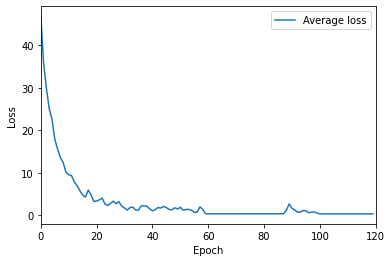

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


average_losses = []

for i, (current_total_loss, number_of_samples) in enumerate(evaluator.train(dataset)):
    print(f'Epoch: {i:03d}, Train Loss: {current_total_loss / number_of_samples}')

    # clear_output(wait=True)

    average_losses.append(current_total_loss / number_of_samples)
    
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.xlim(0, n_epochs)
  
plt.plot(average_losses, label="Average loss")
plt.legend()
plt.show()

# WARNING: Garbage collection takes 20.94% of time!!
# WARNING: Garbage collection takes 196.77% of time!!


In [ ]:
from neuralogic import _std_err, _std_out

from io import StringIO

set_stderr(StringIO())
set_stdout(StringIO())

print(_std_err)
print(_std_out)

In [ ]:
import numpy as np
from collections import Counter

def test(dataset: Dataset) -> float:
    predictions = []
    reals = []

    correct = 0
    print(len(dataset))
    for y, y_hat in evaluator.test(dataset, generator=False):
        # print(f"Expected: {y}, Predicted: {round(y_hat)} ({y_hat})")
        # print(y)
        # print(y_hat)
        # print(np.argmax(y_hat))
        # print(np.argmax(y))
        # print()
        pred = np.argmax(y_hat)
        real = np.argmax(y)
        predictions.append(pred)
        reals.append(real)
        if pred == real:
            correct += 1

    print(sorted(Counter(predictions).items()))
    print(sorted(Counter(reals).items()))

    return float(correct) / len(dataset)

train_accuracy = test(dataset)
print(f'Train set Accuracy: {train_accuracy:.7f}')


# correct = 0


# train_acc = float(correct) / len(dataset)
# print(f"train_acc={train_acc}")


1000


Výstup streamovania bol skrátený na tento počet posledných riadkov: 5000.
Mar 09, 2022 4:56:52 PM cz.cvut.fel.ida.pipelines.pipes.specific.SupervisedNeuralizationPipe lambda$apply$3
INFO: NeuralNet created: s_373:predict(vanessa_303, gabrielle_364): [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]=WeightedAtomNeuron = predict(vanessa_303, gabrielle_364) <- net:g2411, neurons: 32
Mar 09, 2022 4:56:52 PM cz.cvut.fel.ida.neural.networks.structure.transforming.LinearChainReducer reduce
INFO: LinearChainPruning reduced neurons from 32 down to 15 with prunings: 17
Mar 09, 2022 4:56:52 PM cz.cvut.fel.ida.neural.networks.structure.transforming.IsoValueNetworkCompressor reduce
INFO: IsoValue neuron compression from 15 down to 13 etalons (topologic-reconstruction: 13)
Mar 09, 2022 4:56:52 PM cz.cvut.fel.ida.pipelines.pipes.specific.SupervisedNeuralizationPipe lambda$apply$0
INFO: Neuralizing sample s_374: [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]=predict(lisa_368, michael_374) <- ex:#2412 [fact

[(0, 37), (1, 137), (3, 28), (4, 1), (5, 2), (6, 19), (7, 42), (8, 141), (9, 67), (10, 78), (12, 181), (13, 25), (14, 73), (15, 36), (16, 66), (18, 8), (19, 44), (20, 15)]
[(0, 33), (1, 98), (3, 64), (4, 18), (5, 63), (6, 33), (7, 97), (8, 62), (9, 63), (10, 94), (12, 62), (13, 33), (14, 34), (15, 34), (16, 99), (18, 63), (19, 17), (20, 33)]
Train set Accuracy: 0.2310000


Mar 09, 2022 4:58:00 PM cz.cvut.fel.ida.pipelines.pipes.specific.SupervisedNeuralizationPipe lambda$apply$0
INFO: Neuralizing sample s_998: [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]=predict(joe_992, michael_998) <- ex:#3036 [facts:8, (in conjunctions:1, rules:0)]
Mar 09, 2022 4:58:00 PM cz.cvut.fel.ida.pipelines.pipes.specific.SupervisedNeuralizationPipe lambda$apply$3
INFO: NeuralNet created: s_998:predict(joe_992, michael_998): [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]=WeightedAtomNeuron = predict(joe_992, michael_998) <- net:g3036, neurons: 32
Mar 09, 2022 4:58:00 PM cz.cvut.fel.ida.neural.networks.structure.transforming.LinearChainReducer reduce
INFO: LinearChainPruning reduced neurons from 32 down to 15 with prunings: 17
Mar 09, 2022 4:58:00 PM cz.cvut.fel.ida.neural.networks.structure.transforming.IsoValueNetworkCompressor reduce
INFO: IsoValue neuron compression from 15 down to 13 etalons (topologic-reconstruction: 13)
Mar 09, 2022 4:58:00 PM cz.cvut.fel.ida.pipelines.pi

In [ ]:
test_accuracy = test(test_dataset)
# print(f'Epoch: {epoch:03d}, Test Set: {name.rsplit("/")[-1]}, Accuracy: {test_accuracy:.7f}')
print(f'Test Set: {test_set_name.rsplit("/")[-1]}, Accuracy: {test_accuracy:.7f}')


38


Mar 09, 2022 5:00:16 PM cz.cvut.fel.ida.pipelines.Pipeline execute
INFO: Executing pipeline : PythonNNbuilding
Mar 09, 2022 5:00:16 PM cz.cvut.fel.ida.pipelines.pipes.specific.SupervisedNeuralizationPipe lambda$apply$0
INFO: Neuralizing sample s_0: [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]=predict(jason_998, lewis_987) <- ex:#3038 [facts:7, (in conjunctions:1, rules:0)]
Mar 09, 2022 5:00:16 PM cz.cvut.fel.ida.pipelines.pipes.specific.SupervisedNeuralizationPipe lambda$apply$3
INFO: NeuralNet created: s_0:predict(jason_998, lewis_987): [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]=WeightedAtomNeuron = predict(jason_998, lewis_987) <- net:g3038, neurons: 32
Mar 09, 2022 5:00:16 PM cz.cvut.fel.ida.neural.networks.structure.transforming.LinearChainReducer reduce
INFO: LinearChainPruning reduced neurons from 32 down to 15 with prunings: 17
Mar 09, 2022 5:00:16 PM cz.cvut.fel.ida.neural.networks.structure.transforming.IsoValueNetworkCompressor reduce
INFO: IsoValue neuron compression fro

[(1, 7), (6, 2), (7, 3), (9, 4), (10, 5), (12, 7), (15, 8), (19, 2)]
[(3, 19), (10, 19)]
Test Set: 1.2_test.csv, Accuracy: 0.0526316


Mar 09, 2022 5:00:20 PM cz.cvut.fel.ida.pipelines.pipes.specific.SupervisedNeuralizationPipe lambda$apply$0
INFO: Neuralizing sample s_36: [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]=predict(gabrielle_1027, kevin_998) <- ex:#3074 [facts:7, (in conjunctions:1, rules:0)]
Mar 09, 2022 5:00:20 PM cz.cvut.fel.ida.pipelines.pipes.specific.SupervisedNeuralizationPipe lambda$apply$3
INFO: NeuralNet created: s_36:predict(gabrielle_1027, kevin_998): [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]=WeightedAtomNeuron = predict(gabrielle_1027, kevin_998) <- net:g3074, neurons: 32
Mar 09, 2022 5:00:20 PM cz.cvut.fel.ida.neural.networks.structure.transforming.LinearChainReducer reduce
INFO: LinearChainPruning reduced neurons from 32 down to 15 with prunings: 17
Mar 09, 2022 5:00:20 PM cz.cvut.fel.ida.neural.networks.structure.transforming.IsoValueNetworkCompressor reduce
INFO: IsoValue neuron compression from 15 down to 13 etalons (topologic-reconstruction: 13)
Mar 09, 2022 5:00:20 PM cz.cvut.fel.ida

In [ ]:
from neuralogic.core import Template
from neuralogic.utils.templates import GCNConv, TemplateList


template = Template(module_list=TemplateList([
    GCNConv(in_channels=5, out_channels=5),
    GCNConv(in_channels=5, out_channels=1),
]))



In [ ]:
from neuralogic.nn import get_evaluator
from neuralogic.core import Settings, Optimizer, Backend


settings = Settings(learning_rate=0.01, optimizer=Optimizer.SGD, epochs=100)
evaluator = get_evaluator(template, Backend.JAVA, settings)

evaluator.train(dataset, generator=False)


Py4JJavaError: ignored

## CLUTRR - original paper

### Config

In [ ]:
config_dict = {
    "dataset": {
        "base_url": "http://localhost:9300/",
        "common_dict": True,
        "data_path": "data_06b8f2a1",
        "filename": "output.csv",
        "is_preprocessed": True,
        "load_dictionary": False,
        "load_save_path": False,
        "max_vocab": -1,
        "name": "family",
        "save_path": "dtp.pkl",
        "sentence_mode": False,
        "tokenization": "word",
        "train_test_split": 0.8,
        "train_val_split": 0.8,
    },
    "general": {
        "base_path": "",
        "commit_id": "",
        "description": "Sample code. Does not train any model",
        "device": "cuda:0",
        "exp_name": "default",
        "id": "GRAPHSUM1",
        "mode": "train",
        "seed": 42,
    },
    "log": {
        "base_path": "",
        "comet": {
            "api_key": "kYUtsSivX8o6cyO6oF73Q5Deh",
            "disabled": False,
            "project_name": "clutrr",
            "workspace": "koustuvs",
        },
        "file_path": "",
        "logs_per_epoch": 50,
        "predictions": False,
        "test_each_epoch": True,
    },
    "model": {
        "batch_size": 100,
        "beam": {
            "alpha": 0,
            "beam_size": 3,
            "beta": 0,
            "coverage_penalty": 0,
            "length_penalty": 0,
            "max_length": 25,
            "n_best": 1,
        },
        "checkpoint": True,
        "decoder": {
            "bidirectional": False,
            "dropout": 0,
            "hidden_dim": 200,
            "name": "codes.baselines.gat.edge_gat.GatDecoder",
            "nlayers": 2,
            "query_ents": 2,
            "tmp_name": "codes.models.gnn.decoder.GraphLSTMDecoder",
            "use_attention": False,
        },
        "dropout_probability": 0,
        "early_stopping": {"metric_to_track": "val_loss", "patience": 3},
        "early_stopping_patience": 1,
        "embedding": {
            "dim": 100,
            "emb_type": "random",
            "entity_embedding_policy": "fixed",
            "pretrained_embedding_path": "w2v/w2v_sst.txt",
            "should_finetune_embedding": True,
            "should_use_pretrained_embedding": False,
        },
        "encoder": {
            "bidirectional": True,
            "dropout": 0,
            "hidden_dim": 100,
            "invalidate_embeddings": True,
            "name": "codes.baselines.gat.edge_gat.GatEncoder",
            "nlayers": 2,
            "pooling": "maxpool",
            "tmp_name": "codes.models.gnn.encoder.GraphEncoder",
        },
        "graph": {
            "dropout": 0.0,
            "edge_dim": 20,
            "edge_dim_type": "random",
            "edge_embedding": "word",
            "feature_dim": 10,
            "message_dim": 100,
            "message_function": {
                "fn_type": "edge",
                "num_layers": 2,
                "use_attention": True,
                "use_layer_norm": True,
            },
            "node_dim": 100,
            "num_message_rounds": 3,
            "num_reads": 3,
            "pos_dim": 5,
            "pos_rep": "random",
            "readout_function": {"num_layers": 2, "read_mode": "average"},
            "update_function": {
                "fn_type": "lstm",
                "num_layers": 2,
                "use_layer_norm": True,
            },
        },
        "loss_criteria": "CE",
        "loss_type": "classify",
        "name": "graph",
        "num_entity_block": 20,
        "num_epochs": 50,
        "optimiser": {
            "clip": 1,
            "l2_penalty": 0,
            "learning_rate": 0.001,
            "name": "adam",
            "scheduler_gamma": 1,
            "scheduler_patience": 10,
            "scheduler_type": "exp",
        },
        "persist_per_epoch": -1,
        "query_entities": 2,
        "rn": {"f_theta": {"dim_1": 256, "dim_2": 512}, "g_theta_dim": 265},
        "save_dir": "",
        "should_load_model": False,
        "tf_ratio": 1,
    },
    "plot": {"base_path": ""},
}

from addict import Dict
config = Dict(config_dict)

In [ ]:
print(config.dataset.base_url)

http://localhost:9300/


### Data preprocessing

In [ ]:
datadir = path_to("data_7c5b0e70")
print(os.listdir(datadir))
data_config = json.load(open(os.path.join(datadir, 'config.json')))

['1.3_test.csv', 'config.json', '3.3_test.csv', '4.3_test.csv', '2.3_test.csv', '1.2,1.3_train.csv', '1.2_test.csv', 'dict.json']


In [ ]:

train_files = glob.glob(os.path.join(datadir, "*_train.csv"))
assert len(train_files) == 1  # make sure we have only one train file
config.dataset.train_file = train_files[0]
test_files = glob.glob(os.path.join(datadir, "*_test.csv"))
assert len(test_files) > 0  # make sure there exist at least one test file
print(test_files)
print(len(test_files))
print(len(data_config['test_tasks']))
config.dataset.test_files = test_files


['/content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/1.3_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/3.3_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/4.3_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/2.3_test.csv', '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/1.2_test.csv']
5
0


In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### class Batch


In [ ]:
# placeholder class for one batch
import torch
import numpy as np
import itertools as it

class Batch:
    """
    Placeholder class for one batch
    """
    def __init__(self,
            inp=None,                   # story input, (B x s)
            inp_lengths=None,           # length of story, (B x 1)
            s_inp=None,  # story input in sentences (B x s x w) in sentence mode
            sent_lengths=None,          # B x s x 1
            target=None,                # target of the relation, (B x 1)
            text_target = None,         # target in text, (B x t)
            text_target_lengths = None, # target lengths, (B x 1)
            query = None,               # query relation pair, (B x 2)
            query_mask = None,          # query mask over input, (B x s x 2)
            query_text = None,          # query_text input, (B x q)
            query_text_lengths = None,  # query_text lengths, (B x 1)
            inp_ents = None,            # entities per story, (B x e)
            inp_ent_mask = None,        # mask over story which specifies entities, (B x s) / (B x s x w) in sentence mode
            inp_graphs = None,          # story graphs, (B x n x n), where n = max entity in dataset
            sentence_pointer = None,    # each pair of nodes point to a specific sentence by using a one-hot vector over the sentences (in batch mode), (B x n x n x w)
            config = None,
            orig_inp = None,            # Unmodified input
            orig_inp_sent = None,       # Unmodified input, sentence tokenized (list of list)
            inp_row_pos = None,         # position over input text (B x s x w)
            geo_batch = None,           # Pytorch Geometric Batch object (collection of Pytorch Data objects),
            geo_slices = None,          # Pytorch Geometric slices, to restore the original splits
            query_edge = None,          # tensor B x 2 of query edges
            bert_inp = None,            # tensor B x s, right now this contains the entity ids to be used with bert lstm
            bert_input_mask=None,       # input mask, 1 for words and 0 for padding
            bert_segment_ids=None,      # segment id, unique for each sentence
            ):

        """

        :param inp:                     story input, (B x s) / (B x s x w) in sentence mode
        :param inp_lengths:             length of story, (B x 1) / (B x s x 1) in sentence mode
        :param sent_lengths:            B x s x 1
        :param target:                  target of the relation, (B x 1)
        :param text_target:             target in text, (B x t)
        :param text_target_lengths:     target lengths, (B x 1)
        :param query:                   query relation pair, (B x 2)
        :param query_mask:              query mask over input, (B x s x 2)
        :param query_text:              query_text input, (B x q)
        :param query_text_lengths:      query_text lengths, (B x 1)
        :param inp_ents:                entities per story, (B x e)
        :param inp_ent_mask:            mask over story which specifies entities, (B x s) / (B x s x w) in sentence mode
        :param inp_graphs:              story graphs, (B x n x n), where n = max entity in dataset
        :param sentence_pointer:        each pair of nodes point to a specific sentence by using a one-hot vector over the sentences (in batch mode), (B x n x n x w)
        :param config:                  main config file
        :param orig_inp:                Unmodified input
        :param inp_row_pos:             position over input text (B x s x w)
        """

        self.inp = inp
        self.inp_lengths = inp_lengths
        self.s_inp = s_inp
        self.sent_lengths = sent_lengths
        self.target = target
        self.text_target = text_target
        self.text_target_lengths = text_target_lengths
        self.inp_ents = inp_ents
        self.query = query
        self.query_mask = query_mask
        self.query_text = query_text
        self.query_text_lengths = query_text_lengths
        self.inp_ent_mask = inp_ent_mask
        self.inp_graphs = inp_graphs
        self.config = config
        self.batch_size = inp.size(0)
        self.adj_mat = None
        self.encoder_outputs = None
        self.encoder_hidden = None
        # backpointer to encoder model for decoder
        self.encoder_model = None
        self.sentence_pointer = sentence_pointer
        self.orig_inp = orig_inp
        self.orig_inp_sent = orig_inp_sent
        self.inp_row_pos = inp_row_pos
        self.geo_batch = geo_batch
        self.geo_slices = geo_slices
        self.query_edge = query_edge
        self.bert_inp = bert_inp
        self.bert_input_mask = bert_input_mask
        self.bert_segment_ids = bert_segment_ids

    def to_device(self, device):
        self.inp = self.inp.to(device)
        self.s_inp = self.s_inp.to(device)
        self.target = self.target.to(device)
        self.text_target = self.text_target.to(device)
        self.text_target_lengths = self.text_target.to(device)
        self.query = self.query.to(device)
        self.query_mask = self.query_mask.to(device)
        # self.inp_graphs = self.inp_graphs.to(device)
        # self.adj_mat = self.adj_mat.to(device)
        self.inp_ent_mask = self.inp_ent_mask.to(device)
        if self.inp_row_pos is not None:
            self.inp_row_pos = self.inp_row_pos.to(device)
        if self.sentence_pointer is not None:
            self.sentence_pointer = self.sentence_pointer.to(device)
        if self.geo_batch is not None:
            self.geo_batch = self.geo_batch.to(device)
        if self.query_edge is not None:
            self.query_edge = self.query_edge.to(device)
        if self.bert_inp is not None:
            self.bert_inp = self.bert_inp.to(device)
        if self.bert_input_mask is not None:
            self.bert_input_mask = self.bert_input_mask.to(device)
        if self.bert_segment_ids is not None:
            self.bert_segment_ids = self.bert_segment_ids.to(device)

    def _process_adj_mat(self):
        """
        Deprecated.
        Get adjacency matrix of size B x n_e x n_e x n_s x n_dim
        """
        n_e = self.inp_graphs.size(1)
        n_s = self.config.model.graph.num_reads
        n_dim = self.config.model.graph.edge_dim
        self.adj_mat = torch.zeros((self.batch_size, n_e, n_e, n_s, n_dim))

    def clone(self):
        return Batch(inp=self.inp.clone().detach(),
                     inp_lengths=self.inp_lengths,
                     s_inp=self.s_inp.clone().detach(),
                     sent_lengths=self.sent_lengths,  # B x s x 1
                     target=self.target.clone().detach(),  # target of the relation, (B x 1)
                     text_target=self.text_target.clone().detach(),  # target in text, (B x t)
                     text_target_lengths=self.text_target.clone().detach(),  # target lengths, (B x 1)
                     query=self.query.clone().detach(),  # query relation pair, (B x 2)
                     query_mask=self.query_mask.clone().detach(),  # query mask over input, (B x s x 2)
                     query_text=self.query_text,  # query_text input, (B x q)
                     query_text_lengths=self.query_text_lengths,  # query_text lengths, (B x 1)
                     inp_ents=self.inp_ents,  # entities per story, (B x e)
                     inp_ent_mask=self.inp_ent_mask.clone().detach(),
                     # mask over story which specifies entities, (B x s) / (B x s x w) in sentence mode
                     inp_graphs=None,  # story graphs, (B x n x n), where n = max entity in dataset
                     sentence_pointer=None,
                     # each pair of nodes point to a specific sentence by using a one-hot vector over the sentences (in batch mode), (B x n x n x w)
                     config=self.config,
                     orig_inp=self.orig_inp,  # Unmodified input
                     orig_inp_sent=self.orig_inp_sent, # Unmodified input, sentence tokenized
                     inp_row_pos=None,  # position over input text (B x s x w)
                     geo_batch=self.geo_batch,  # Pytorch Geometric Batch object (collection of Pytorch Data objects),
                     geo_slices=self.geo_slices,  # Pytorch Geometric slices, to restore the original splits
                     query_edge=self.query_edge.clone().detach(),
                     bert_inp=self.bert_inp.clone().detach(), # right now this contains the entity ids to be used with bert lstm
                     bert_input_mask=self.bert_input_mask.clone().detach(),
                     bert_segment_ids=self.bert_segment_ids.clone().detach()
                     )






### class DataUtility

In [ ]:
import torch
import torch.utils.data as data
import re
import pandas as pd
import json
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import pickle as pkl
import itertools as it
from addict import Dict
# from codes.net.batch import Batch
# from codes.utils.config import get_config
import os
import json
from ast import literal_eval as make_tuple
from torch_geometric.data import Data as GeometricData
from torch_geometric.data import Batch as GeometricBatch
import random
from itertools import repeat, product
from typing import List
# from codes.utils.bert_utils import BertLocalCache
# from pytorch_pretrained_bert.tokenization import BertTokenizer

UNK_WORD = '<unk>'
PAD_TOKEN = '<pad>'
START_TOKEN = '<s>'
END_TOKEN = '</s>'
# bert tokens
CLS_TOKEN = "[CLS]"
SEP_TOKEN = "[SEP]"


class DataRow():
    """
    Defines a single instance of data row
    """
    def __init__(self):
        self.id = None
        self.story = None
        self.story_sents = None # same story, but sentence tokenized
        self.query = None
        self.text_query = None
        self.target = None
        self.text_target = None
        self.story_graph = None
        # new variables to only contain the clean graph for Exp 3
        self.story_edges = None
        self.edge_types = None
        self.query_edge = None
        # processed attributes
        self.pattrs = []

class DataUtility():
    """
    Data preparation and utility class
    """
    def __init__(self,
                 config,
                 num_workers=4,
                 common_dict=True):
        """

        :param main_file: file where the summarization resides
        :param train_test_split: default 0.8
        :param sentence_mode: if sentence_mode == True, then split story into sentence
        :param single_abs_line: if True, then output pair is single sentences of abs
        :param num_reads: number of reads for a sentence
        :param dim: dimension of edges
        """
        self.config = config
        # derive configurations
        self.train_test_split = config.dataset.train_test_split
        self.max_vocab = config.dataset.max_vocab
        self.tokenization = config.dataset.tokenization
        self.common_dict = config.dataset.common_dict
        self.batch_size = config.model.batch_size
        self.num_reads = config.model.graph.num_reads
        self.dim = config.model.graph.edge_dim
        self.sentence_mode = config.dataset.sentence_mode
        self.single_abs_line = config.dataset.single_abs_line
        self.num_entity_block = config.model.num_entity_block  # number of entity vectors we want to block off
        self.process_bert = config.dataset.process_bert
        if self.process_bert:
            self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

        self.word2id = {}
        self.id2word = {}
        self.target_word2id = {}
        self.target_id2word = {}
        # dict of dataRows
        # all rows are indexed by their key `id`
        self.dataRows = {'train':{}, 'test':{}}

        self.train_indices = []
        self.test_indices = []
        self.val_indices = []
        self.special_tokens = [PAD_TOKEN, UNK_WORD, START_TOKEN, END_TOKEN]
        self.main_file = ''
        self.common_dict = common_dict
        self.num_workers = num_workers
        # keep some part of the vocab fixed for the entities
        # for that we need to first calculate the max number of unique entities *per row*
        self.train_data = None
        self.test_data = None
        self.train_file = ''
        self.test_file = ''
        self.max_ents = 0
        self.entity_ids = []
        self.entity_map = {} # map entity for each puzzle
        self.max_entity_id = 0
        self.adj_graph = []
        self.dummy_entity = '' # return this entity when UNK entity
        self.load_dictionary = config.dataset.load_dictionary
        self.max_sent_length = 0
        self.unique_edge_dict = {}
        # check_data flags
        self.data_has_query = False
        self.data_has_text_query = False
        self.data_has_target = False
        self.data_has_text_target = False
        self.data_has_raw_graph = False
        self.preprocessed = set() # set of puzzle ids which has been preprocessed
        self.max_sent_length = 0
        self.max_word_length = 0
        self.unique_nodes = set() # nodes for the raw graph

    def process_data(self, base_path, train_file, load_dictionary=True, preprocess=True):
        """
        Load data and run preprocessing scripts
        :param main_file .csv file of the data
        :return:
        """
        self.train_file = train_file
        train_data = pd.read_csv(self.train_file, comment='#')
        train_data = self._check_data(train_data)
        print("Start preprocessing data")
        if load_dictionary:
            dictionary_file = os.path.join(base_path, 'dict.json')
            print("Loading dictionary from {}".format(dictionary_file))
            dictionary = json.load(open(dictionary_file))
            # fix id2word keys
            dictionary['id2word'] = {int(k):v for k,v in dictionary['id2word'].items()}
            dictionary['target_id2word'] = {int(k): v for k, v in dictionary['target_id2word'].items()}
            for key, value in dictionary.items():
                setattr(self, key, value)
        train_data, max_ents_train, = self.process_entities(train_data)
        if preprocess:
            self.preprocess(train_data, mode='train')
            self.train_data = train_data
            self.split_indices()
        else:
            return train_data, max_ents_train

    def process_test_data(self, base_path, test_files):
        """
        Load testing data
        :param test_files: array of file names
        :return:
        """
        self.test_files = test_files #[os.path.join(base_path, t) + '_test.csv' for t in test_files]
        test_datas = [pd.read_csv(tf, comment='#') for tf in self.test_files]
        for test_data in test_datas:
            self._check_data(test_data)
        print("Loaded test data, starting preprocessing")
        p_tests = []
        for ti, test_data in enumerate(test_datas):
            test_data, max_ents_test, = self.process_entities(test_data)
            self.preprocess(test_data, mode='test',
                            test_file=test_files[ti])
            p_tests.append(test_data)
        self.test_data = p_tests
        print("Done preprocessing test data")


    def _check_data(self, data):
        """
        Check if the file has correct headers.
        For all the subsequent experiments, make sure that the dataset generated
        or curated has the following fields:
        - id : unique uuid for each puzzle          : required
        - story : input text                        : required
        - query : query entities                    : optional
        - text_query : the question for QA models   : optional
        - target : classification target            : required if config.model.loss_type set to classify
        - text_target : seq2seq target              : required if config.model.loss_type set to seq2seq
        :param data:
        :return: data
        """
        # check for required stuff
        assert "id" in list(data.columns)
        assert "story" in list(data.columns)
        if self.config.model.loss_type == 'classify':
            assert "target" in list(data.columns)
        if self.config.model.loss_type == 'seq2seq':
            assert "text_target" in list(data.columns)
        # turn on flag if present
        if "target" in list(data.columns):
            self.data_has_target = True
        if "text_target" in list(data.columns):
            self.data_has_text_target = True
        if "query" in list(data.columns) and len(data['query'].value_counts()) > 0:
            self.data_has_query = True
        else:
            data['query'] = ''
        if "text_query" in list(data.columns) and len(data['text_query'].value_counts()) > 0:
            self.data_has_text_query = True
        else:
            data['text_query'] = ''
        if "story_edges" in list(data.columns) and "edge_types" in list(data.columns) and "query_edge" in list(data.columns):
            self.data_has_raw_graph = True
        return data

    def process_entities(self, data, placeholder='[]'):
        """
        extract entities and replace them with placeholders.
        Also maintain a per-puzzle mapping of entities
        :param placeholder: if [] then simply use regex to extract entities as they are already in
        a placeholder. If None, then use Spacy EntityTokenizer
        :return: max number of entities in dataset
        """
        max_ents = 0
        if placeholder == '[]':
            for i,row in data.iterrows():
                story = row['story']
                ents = re.findall('\[(.*?)\]', story)
                uniq_ents = set(ents)
                uniq_ents = random.sample(list(uniq_ents), len(uniq_ents))
                pid = row['id']
                query = row['query'] if self.data_has_query else ''
                query = list(make_tuple(query))
                text_query = row['text_query'] if self.data_has_text_query else ''
                text_target = row['text_target'] if self.data_has_text_target else ''
                entity_map = {}
                entity_id_block = list(range(0, len(uniq_ents)))
                for idx, ent in enumerate(uniq_ents):
                    entity_id = random.choice(entity_id_block)
                    entity_id_block.remove(entity_id)
                    if self.process_bert:
                        # if bert, then replace the entities with pure numbers, as otherwise we would not
                        # have an unique embedding. Also, make sure the text doesn't contain any numbers before hand
                        # TODO: remove numbers
                        entity_map[ent] = '{}'.format(entity_id)
                    else:
                        entity_map[ent] = '@ent{}'.format(entity_id)
                    story = story.replace('[{}]'.format(ent), entity_map[ent])
                    text_target = text_target.replace('[{}]'.format(ent), entity_map[ent])
                    text_query = text_query.replace('[{}]'.format(ent), entity_map[ent])
                    try:
                        ent_index = query.index(ent)
                        query[ent_index] = entity_map[ent]
                    except ValueError:
                        pass
                data.at[i, 'story'] = story
                data.at[i, 'text_target'] = text_target
                data.at[i, 'text_query'] = text_query
                data.at[i, 'query'] = tuple(query)
                data.at[i, 'entities'] = json.dumps(list(uniq_ents))
                self.entity_map[pid] = entity_map
                max_ents = max(max_ents, len(uniq_ents))
        else:
            raise NotImplementedError("Not implemented, should replace with a tokenization policy")
        self.num_entity_block = max(max_ents, self.num_entity_block)
        return data, max_ents

    def preprocess(self, data, mode='train', single_abs_line=True, test_file=''):
        """
        Usual preprocessing: tokenization, lowercase, and create word dictionaries
        Also, split stories into sentences
        :param single_abs_line: if True, separate the abstracts into its corresponding lines
        and add each story-abstract pairs
        N.B. change: dropping `common_dict=True` as I am assuming I will always use a common
        dictionary for reasoning and QA. Separate dictionary makes sense for translation which
        I am not working at the moment.
        :return:
        """

        words = Counter()
        max_sent_length = 0
        max_word_length = 0
        if self.data_has_target:
            # assign target ids
            self.assign_target_id(list(data['target']))

        for i,row in data.iterrows():
            dataRow = DataRow()
            dataRow.id = row['id']
            story_sents = sent_tokenize(row['story'])
            if self.process_bert:
                story_sents = [self.bert_tokenizer.tokenize(sent) for sent in story_sents]
            else:
                story_sents = [self.tokenize(sent) for sent in story_sents]
            if self.process_bert:
                story_sents = [sent + [SEP_TOKEN] for sent in story_sents]
                story_sents[0] = [CLS_TOKEN] + story_sents[0] 
            words.update([word for sent in story_sents for word in sent])
            dataRow.story_sents = story_sents
            dataRow.story = [word for sent in story_sents for word in sent] # flatten
            max_word_length = max(max_word_length, len(dataRow.story))
            if self.data_has_text_target:
                # preprocess text_target
                text_target = self.tokenize(row['text_target'])
                dataRow.text_target = text_target
                words.update([word for word in text_target])
            if self.data_has_text_query:
                # preprocess text_query
                if self.process_bert:
                    text_query = self.bert_tokenizer.tokenize(row['text_query'])
                else:
                    text_query = self.tokenize(row['text_query'])
                dataRow.text_query = text_query
                words.update([word for word in text_query])
            max_sl = max([len(s) for s in story_sents])
            if max_sl > max_sent_length:
                max_sent_length = max_sl
            if self.data_has_query:
                dataRow.query = row['query']
            if self.data_has_target:
                dataRow.target = self.target_word2id[row['target']]
            if self.data_has_raw_graph:
                # add the raw graph and edge ids
                dataRow.story_edges = list(make_tuple(row['story_edges']))
                dataRow.edge_types = make_tuple(row['edge_types'])
                dataRow.query_edge = make_tuple(row['query_edge'])
                unique_nodes = [n for edge in dataRow.story_edges for n in edge]
                self.unique_nodes.update(unique_nodes)
                for et in dataRow.edge_types:
                    if et not in self.unique_edge_dict:
                        self.unique_edge_dict[et] = len(self.unique_edge_dict)

            if mode == 'train':
                self.dataRows[mode][dataRow.id] = dataRow
            else:
                if test_file not in self.dataRows[mode]:
                    self.dataRows[mode][test_file] = {}
                self.dataRows[mode][test_file][dataRow.id] = dataRow
            self.preprocessed.add(dataRow.id)

        # only assign word-ids in train data
        if mode == 'train' and not self.load_dictionary:
            self.assign_wordids(words)

        # get adj graph
        ct = 0
        if mode == 'train':
            for i, row in data.iterrows():
                dR = self.dataRows[mode][row['id']]
                #  dR.story_graph = self.prepare_ent_graph(dR.story_sents)
                ct += 1
            print("Processed {} stories in mode {}".format(ct,
                                                                  mode))
            self.max_sent_length = max_sent_length
        else:
            for i,row in data.iterrows():
                dR = self.dataRows[mode][test_file][row['id']]
                # dR.story_graph = self.prepare_ent_graph(dR.story_sents)
                ct +=1
            print("Processed {} stories in mode {} and file: {}".format(
                ct, mode, test_file))

        # update the max sentence length
        self.max_word_length = max(self.max_word_length, max_word_length)



    def tokenize(self, sent):
        """
        tokenize sentence based on mode
        :sent - sentence
        :param mode: word/char
        :return: splitted array
        """
        words = []
        if self.tokenization == 'word':
            words = word_tokenize(sent)
        if self.tokenization == 'char':
            words = sent.split('')
        # correct for tokenizing @entity
        corr_w = []
        tmp_w = ''
        for i,w in enumerate(words):
            if w == '@':
                tmp_w = w
            else:
                tmp_w += w
                corr_w.append(tmp_w)
                tmp_w = ''
        return corr_w

    def _insert_wordid(self, token, id):
        if token not in self.word2id:
            assert id not in set([v for k,v in self.word2id.items()])
            self.word2id[token] = id
            self.id2word[id] = token

    def assign_wordids(self, words, special_tokens=None):
        """
        Given a set of words, create word2id and id2word
        :param words: set of words
        :param special_tokens: set of special tokens to add into dictionary
        :return:
        """
        count = 0
        if not special_tokens:
            special_tokens = self.special_tokens
        ## if max_vocab is not -1, then shrink the word size
        if self.max_vocab >= 0:
            words = [tup[0] for tup in words.most_common(self.max_vocab)]
        else:
            words = list(words.keys())
        # add pad token
        self._insert_wordid(PAD_TOKEN, count)
        count +=1
        # reserve a block for entities. Record this block for future use.
        start_ent_num = count
        for idx in range(self.num_entity_block):
            self._insert_wordid('@ent{}'.format(idx), count)
            count +=1
        # not reserving a dummy entity now as we are reserving a whole block
        # reserve a dummy entity
        # self.dummy_entity = '@ent{}'.format(self.max_ents - 1)
        # self._insert_wordid(self.dummy_entity, count)
        # count += 1
        end_ent_num = count
        self.max_entity_id = end_ent_num - 1
        self.entity_ids = list(range(start_ent_num, end_ent_num))
        # add other special tokens
        if special_tokens:
            for tok in special_tokens:
                if tok == PAD_TOKEN:
                    continue
                else:
                    self._insert_wordid(tok, count)
                    count += 1
        # finally add the words
        for word in words:
            if word not in self.word2id:
                self._insert_wordid(word, len(self.word2id))
                #count += 1

        print("Modified dictionary. Words : {}, Entities : {}".format(
            len(self.word2id), len(self.entity_ids)))

    def assign_target_id(self, targets):
        """
        Assign IDS to targets
        :param targets:
        :return:
        """
        for target in set(targets):
            if target not in self.target_word2id:
                last_id = len(self.target_word2id)
                self.target_word2id[target] = last_id
        self.target_id2word = {v: k for k, v in self.target_word2id.items()}
        print("Target Entities : {}".format(len(self.target_word2id)))

    def split_indices(self):
        """
        Split training file indices into training and validation
        Now we use separate testing file
        :return:
        """
        print("splitting data ...")
        indices = list(self.dataRows['train'].keys())
        mask_i = np.random.choice(indices, int(len(indices) * self.train_test_split), replace=False)
        self.val_indices = [self.dataRows['train'][i].id for i in indices if i not in set(mask_i)]
        self.train_indices = [self.dataRows['train'][i].id for i in indices if i in set(mask_i)]


    def prepare_ent_graph(self, sents, max_nodes=0):
        """
        Given a list of sentences, return an adjacency matrix between entities
        Assumes entities have the format @ent{num}
        We can use OpenIE in later editions to automatically detect entities
        :param sents: list(list(str))
        :param max_nodes: max number of nodes in the adjacency matrix, int
        :return: list(list(int))
        """
        if max_nodes == 0:
            max_nodes = len(self.entity_ids)
        adj_mat = np.zeros((max_nodes, max_nodes))
        for sent in sents:
            ents = list(set([w for w in sent if '@ent' in w]))
            if len(ents) > 1:
                for ent1, ent2 in it.combinations(ents, 2):
                    ent1_id = self.get_entity_id(ent1) - 1
                    ent2_id = self.get_entity_id(ent2) - 1
                    adj_mat[ent1_id][ent2_id] = 1
                    adj_mat[ent2_id][ent1_id] = 1
        return adj_mat

    def prepare_for_dataloader(self, dataRows:List[DataRow], bert_cache=None) -> List[DataRow]:
        """
        Offload processing from dataloader get_item to here.
        :param dataRows:
        :return:
        """
        for dataRow in dataRows:
            orig_inp = dataRow.story
            orig_inp_sent = dataRow.story_sents
            # This is bert_as_a_service code. Now trying hugging face code
            # bert_inp = bert_cache.query(orig_inp_sent)
            # here batch size is number of sentences. convert it back to one concatenation
            # 2 x 10 x 768  -> 1 x 20 x 768
            # bert_inp = bert_inp.view(1,-1,bert_inp.size(2))
            bert_inp = None

            # inp_row_graph = dataRow.story_graph
            inp_row_pos = []

            # for sentence tokenizations
            sent_lengths = [len(sent) for sent in dataRow.story_sents]
            if self.process_bert:
                s_inp_row = [self.bert_tokenizer.convert_tokens_to_ids(sent) for sent in dataRow.story_sents]
            else:
                s_inp_row = [[self.get_token(word) for word in sent] for sent in dataRow.story_sents]
            #s_inp_ents = [[id for id in sent if id in self.entity_ids] for sent in inp_row]
            #s_inp_row_pos = [[widx + 1 for widx, word in enumerate(sent)] for sent in inp_row]

            # for word tokenizations
            # sent_lengths = [len(dataRow.story)]
            bert_entity_dict = {}
            if self.process_bert:
                inp_row = [word for sent in s_inp_row for word in sent]
                entity_ids = [str(x-1) for x in self.entity_ids] # -1 to accomodate 0
                bert_entity_ids = self.bert_tokenizer.convert_tokens_to_ids(entity_ids)
                for entid, b_entid in zip(entity_ids, bert_entity_ids):
                    bert_entity_dict[b_entid] = entid
                inp_ents = list(set(id for id in inp_row if id in bert_entity_ids))
            else:
                inp_row = [self.get_token(word) for word in dataRow.story]
                inp_ents = list(set([id for id in inp_row if id in self.entity_ids]))

            # bert specific variables
            bert_input_mask = [1] * len(inp_row)
            # for BERT, the segment ids denote each sentence.
            bert_segment_ids = []
            for s_id, sent in enumerate(s_inp_row):
                bert_segment_ids.extend([0]*len(sent))


            ## calculate one-hot mask for entities which are used in this row
            flat_inp_ents = inp_ents
            if self.sentence_mode:
                flat_inp_ents = [p for x in inp_ents for p in x]

            if self.process_bert:
                inp_ent_mask = [1 if w in bert_entity_dict else 0 for w in inp_row]
                bert_inp = [int(bert_entity_dict[w])+1 if w in bert_entity_dict else 0 for w in inp_row]
            else:
                inp_ent_mask = [1 if idx + 1 in flat_inp_ents else 0 for idx in range(len(self.entity_ids))]
                bert_inp = inp_row  # dummy

            # calculate for each entity pair which sentences contain them
            # output should be a max_entity x max_entity x num_sentences --> which should be later padded
            # if not sentence mode, then just output max_entity x max_entity x 1
            num_sents = len(inp_row)  # 8, say
            if self.sentence_mode:
                assert len(inp_row) == len(inp_ents)
                sentence_pointer = np.zeros((len(self.entity_ids), len(self.entity_ids),
                                             num_sents))
                for sent_idx, inp_ent in enumerate(inp_ents):
                    if len(inp_ent) > 1:
                        for ent1, ent2 in it.combinations(inp_ent, 2):
                            # check if two same entities are not appearing
                            if ent1 == ent2:
                                raise NotImplementedError(
                                    "For now two same entities cannot appear in the same sentence")
                            assert ent1 != ent2
                            # remember we are shifting one bit here
                            sentence_pointer[ent1 - 1][ent2 - 1][sent_idx] = 1

            else:
                sentence_pointer = np.ones((len(self.entity_ids), len(self.entity_ids), 1))

            # calculate the output
            target = [dataRow.target]
            if self.process_bert:
                query = self.bert_tokenizer.convert_tokens_to_ids(list(dataRow.query))
            else:
                query = [self.get_token(tp) for tp in dataRow.query]  # tuple
                # debugging
                if self.get_token('UNKUNK') in query:
                    print("shit")
                    raise AssertionError("Unknown element cannot be in the query. Check the data.")
            # one hot integer mask over the input text which specifies the query strings
            query_mask = [[1 if w == ent else 0 for w in self.__flatten__(inp_row)] for ent in query]
            # TODO: use query_text and query_text length and pass it back
            # text_query = [self.data.get_token(tp) for tp in self.dataRows[index].text_query]
            text_query = []
            text_target = [START_TOKEN] + dataRow.text_target + [END_TOKEN]
            text_target = [self.get_token(tp) for tp in text_target]

            # clean graphs for GAT
            edge_list = dataRow.story_edges  # eg, [(0, 1), (1, 2), (2, 3)]
            edge_index = list(zip(*edge_list))  # eg, [[0, 1, 2], [1, 2, 3]]
            edge_index = torch.LongTensor(edge_index)  # 2 x num_edges
            edge_types = dataRow.edge_types
            num_ue = len(self.unique_edge_dict)
            num_e = len(edge_list)
            edge_attr = torch.zeros(num_e, 1).long()  # [num_edges, 1]
            # create a one-hot vector for each edge type
            for i, e in enumerate(edge_types):
                edge_attr[i][0] = self.unique_edge_dict[e]
            nodes = list(set([p for x in edge_list for p in x]))
            x = torch.arange(len(nodes)).unsqueeze(1)  # num_nodes x 1

            geo_data = {'x': x, 'edge_index': edge_index, 'edge_attr': edge_attr, 'y': torch.tensor(target),
                        'num_nodes': len(nodes)}
            query_edge = [dataRow.query_edge]
            num_nodes = [len(nodes)]
            dataRow.pattrs = [inp_row, s_inp_row, inp_ents, query, text_query, query_mask, target, text_target,
               sent_lengths, inp_ent_mask, geo_data, query_edge, num_nodes, sentence_pointer, orig_inp, orig_inp_sent, bert_inp,
                              inp_row_pos, bert_input_mask, bert_segment_ids]
        return dataRows


    def get_dataloader(self, mode='train', test_file='', bert_cache=None):
        """
        Return a new SequenceDataLoader instance with appropriate rows
        :param mode: train/val/test
        :return: SequenceDataLoader object
        """
        if mode != 'test':
            if mode == 'train':
                indices = self.train_indices
            else:
                indices = self.val_indices
            dataRows = self._select(self.dataRows['train'], indices)
        else:
            dataRows = [v for k,v in self.dataRows['test'][test_file].items()]

        print(len(self.dataRows['train']))
        print(len(self.dataRows['test']))

        print("Total rows : {}, batches : {}"
                     .format(len(dataRows),
                             len(dataRows) // self.batch_size))

        collate_FN = collate_fn
        if self.sentence_mode:
            collate_FN = sent_collate_fn

        dataRows = self.prepare_for_dataloader(dataRows, bert_cache)

        """
        return data.DataLoader(SequenceDataLoader(dataRows),
                               batch_size=self.batch_size,
                               num_workers=self.num_workers,
                               collate_fn=collate_FN)
        """
        batches = self.precompute_batches(dataRows)

        return data.DataLoader(PreComputedDataLoader(batches),batch_size=1, collate_fn=pre_collate_fn)


    def precompute_batches(self, dataRows:List[DataRow]):
        print("precomputing batches...")
        batch_size = self.config.model.batch_size
        batches = []
        for i in range(0, len(dataRows), batch_size):
            data = [dataRows[i].pattrs for i in range(i, i+batch_size) if i < len(dataRows)]
            data.sort(key=lambda x: len(x[0]), reverse=True)
            inp_data, s_inp_data, inp_ents, query, text_query, query_mask, target, text_target, \
            sent_lengths, inp_ent_mask, geo_data, query_edge, num_nodes, \
            sentence_pointer, orig_inp, orig_inp_sent, bert_inp, _, bert_input_mask, bert_segment_ids = zip(
                *data)
            inp_data, inp_lengths = simple_merge(inp_data)
            s_inp_data, sent_lengths = sent_merge(s_inp_data, sent_lengths)
            # outp_data, outp_lengths = simple_merge(outp_data)
            text_target, text_target_lengths = simple_merge(text_target)
            bert_input_mask, _ = simple_merge(bert_input_mask)
            bert_segment_ids, _ = simple_merge(bert_segment_ids)
            inp_ent_mask,_ = simple_merge(inp_ent_mask)

            query = torch.LongTensor(query)
            query_mask = pad_ents(query_mask, inp_lengths)
            target = torch.LongTensor(target)
            # geo_data_col, geo_data_slices = collate_geometric(geo_data)
            slices = [p for n in num_nodes for p in n]
            max_node = max(slices)
            # add extra node to all graphs in order to have padding
            geo_data = [GeometricData(x=torch.arange(max_node).unsqueeze(1), edge_index=gd['edge_index'],
                                      edge_attr=gd['edge_attr'], y=gd['y']) for gd in geo_data]
            geo_batch = GeometricBatch.from_data_list(geo_data)
            # update the slices - same number of nodes
            slices = [max_node for s in slices]
            query_edge = torch.LongTensor(query_edge)
            bert_inp,_ = simple_merge(bert_inp) #torch.cat(bert_inp, dim=0)
            # assert bert_inp.size(0) == batch_size

            # prepare batch
            batch = Batch(
                inp=inp_data,
                s_inp=s_inp_data,
                inp_lengths=inp_lengths,
                sent_lengths=sent_lengths,
                orig_inp=orig_inp,
                orig_inp_sent=orig_inp_sent,
                bert_inp=bert_inp,
                target=target,
                text_target=text_target,
                text_target_lengths=text_target_lengths,
                inp_ents=inp_ents,
                query=query,
                query_mask=query_mask,
                inp_ent_mask=inp_ent_mask,
                geo_batch=geo_batch,
                query_edge=query_edge,
                geo_slices=slices,
                bert_segment_ids=bert_segment_ids,
                bert_input_mask=bert_input_mask
            )
            #batch.to_device('cuda')
            batches.append(batch)
        print("done precomputing batches {}".format(len(batches)))
        return batches

    def update_bert_cache(self, bert_cache):
        """
        Preload all sentences from BERT
        :param bert_cache:
        :return:
        """
        print("Bert caching train rows .. ")
        for idx, dataRow in self.dataRows['train'].items():
            bert_cache.update_cache(dataRow.story_sents)
        print("Bert caching test rows .. ")
        for flname, dataRows in self.dataRows['test'].items():
            for idx, dataRow in dataRows.items():
                bert_cache.update_cache(dataRow.story_sents)
        bert_cache.run_bert()


    def map_text_to_id(self, text):
        if isinstance(text, list):
            return list(map(self.get_token, text))
        else:
            return self.get_token(text)

    def get_token(self, word, target=False):
        if target and word in self.target_word2id:
            return self.target_word2id[word]
        elif word in self.word2id:
            return self.word2id[word]
        else:
            return self.word2id[UNK_WORD]

    def get_entity_id(self, entity):
        if entity in self.word2id:
            return self.word2id[entity]
        else:
            return self.word2id[self.dummy_entity]

    def _filter(self, array, mask):
        """
        filter array based on boolean mask
        :param array: any array
        :param mask: boolean mask
        :return: filtered
        """
        return [array[i] for i,p in enumerate(mask) if p]

    def _select(self, array, indices):
        """
        Select based on ids
        :param array:
        :param indices:
        :return:
        """
        return [array[i] for i in indices]

    def __flatten__(self, arr):
        if any(isinstance(el, list) for el in arr):
            return [a for b in arr for a in b]
        else:
            return arr

    def save(self, filename='data_files.pkl'):
        """
        Save the current data utility into pickle file
        :param filename: location
        :return: None
        """
        #pkl.dump(self.__dict__, open(filename, 'wb'))
        print("Saved data in {}".format(filename))

    def load(self, filename='data_files.pkl'):
        """
        Load previously saved data utility
        :param filename: location
        :return:
        """
        #print("Loading data from {}".format(filename))
        #self.__dict__.update(pkl.load(open(filename,'rb')))
        print("Loaded")

def generate_dictionary(config):
    """
    Before running an experiment, make sure that a dictionary
    is generated
    Check if the dictionary is present, if so then return
    :return:
    """
    dictionary_file = os.path.join(datadir, 'dict.json')
    if os.path.isfile(dictionary_file):
        print("Dictionary present at {}".format(dictionary_file))
        return
    print("Creating dictionary with all test files")
    ds = DataUtility(config)
    datas = []
    print("For training file")
    train_data, max_ents = ds.process_data(datadir, config.dataset.train_file, load_dictionary=False, preprocess=False)
    datas.append(train_data)
    print("For testing files")
    for test_file in config.dataset.test_files:
        print("For file {}".format(test_file))
        test_data, max_e = ds.process_data(datadir, test_file, load_dictionary=False, preprocess=False)
        datas.append(test_data)
        if max_e > max_ents:
            max_ents = max_e
    ds.max_ents = max_ents
    print("Processing words...")
    for data in datas:
        ds.preprocess(data)

    # save dictionary
    dictionary = {
        'word2id': ds.word2id,
        'id2word': ds.id2word,
        'target_word2id': ds.target_word2id,
        'target_id2word': ds.target_id2word,
        'max_ents': ds.max_ents,
        'max_vocab': ds.max_vocab,
        'max_entity_id': ds.max_entity_id,
        'entity_ids': ds.entity_ids,
        'dummy_entitiy': ds.dummy_entity,
        'entity_map': ds.entity_map
    }
    json.dump(dictionary, open(dictionary_file,'w'))
    print("Saved dictionary at {}".format(dictionary_file))


### class Dataloader

In [ ]:

class SequenceDataLoader(data.Dataset):
    """
    Separate dataloader instance
    """

    def __init__(self, dataRows:List[DataRow]):
        """
        :param dataRows: training / validation / test data rows
        :param data: pointer to DataUtility class
        """
        self.dataRows = dataRows

    def __getitem__(self, index):
        """
        Return single training row for dataloader
        :param item:
        :return:
        """
        return self.dataRows[index].pattrs

    def __len__(self):
        return len(self.dataRows)


class PreComputedDataLoader(data.Dataset):
    """
    Separate dataloader instance
    """

    def __init__(self, batches):
        """
        :param dataRows: training / validation / test data rows
        :param data: pointer to DataUtility class
        """
        self.batches = batches

    def __getitem__(self, index):
        """
        Return single training row for dataloader
        :param item:
        :return:
        """
        return self.batches[index].clone()

    def __len__(self):
        return len(self.batches)

def pre_collate_fn(data):
    assert len(data) == 1
    return data[0]


## Helper functions
def simple_merge(rows):
    lengths = [len(row) for row in rows]
    padded_rows = pad_rows(rows, lengths)
    return padded_rows, lengths

def nested_merge(rows):
    lengths = []
    for row in rows:
        row_length = [len(current_row) for current_row in row]
        lengths.append(row_length)

    # lengths = [len(row) for row in rows]
    padded_rows = pad_nested_row(rows, lengths)
    return padded_rows, lengths

def simple_np_merge(rows):
    lengths = [len(row) for row in rows]
    padded_rows = pad_rows(rows, lengths)
    return padded_rows, lengths

def collate_fn(data):
    """
    helper function for torch.DataLoader
    :param data: list of tuples (inp, outp)
    :return:
    """
    ## sort dataset by inp sentences
    data.sort(key=lambda x: len(x[0]), reverse=True)
    inp_data, s_inp_data, inp_ents, query, text_query, query_mask, target, text_target, sent_lengths, inp_ent_mask, geo_data, query_edge, num_nodes, *_ = zip(*data)
    inp_data, inp_lengths = simple_merge(inp_data)
    s_inp_data, sent_lengths = sent_merge(s_inp_data, sent_lengths)
    # outp_data, outp_lengths = simple_merge(outp_data)
    text_target, text_target_lengths = simple_merge(text_target)

    query = torch.LongTensor(query)
    query_mask = pad_ents(query_mask, inp_lengths)
    target = torch.LongTensor(target)
    #geo_data_col, geo_data_slices = collate_geometric(geo_data)
    slices = [p for n in num_nodes for p in n]
    max_node = max(slices)
    # add extra node to all graphs in order to have padding
    geo_data = [GeometricData(x=torch.arange(max_node).unsqueeze(1), edge_index=gd['edge_index'], edge_attr=gd['edge_attr'], y=gd['y']) for gd in geo_data]
    geo_batch = GeometricBatch.from_data_list(geo_data)
    # update the slices - same number of nodes
    slices = [max_node for s in slices]
    query_edge = torch.LongTensor(query_edge)

    # prepare batch
    batch = Batch(
        inp=inp_data,
        s_inp=s_inp_data,
        inp_lengths=inp_lengths,
        sent_lengths=sent_lengths,
        target=target,
        text_target=text_target,
        text_target_lengths=text_target_lengths,
        inp_ents=inp_ents,
        query=query,
        query_mask=query_mask,
        inp_ent_mask = torch.LongTensor(inp_ent_mask),
        geo_batch=geo_batch,
        query_edge=query_edge,
        geo_slices=slices
    )

    return batch

def sent_merge(rows, sent_lengths):
    """
    :param rows: [[[a,b],[c,d,e]], [[b,c,d,e],[d,e,f],[g,t]]]
    :param sent_lengths: [[2,3],[4,3,2]]

    padded_rows = 2 x 3 x 4
    :return:
    """
    lengths = [len(row) for row in rows] # number of sent in each batch
    max_sent_l = max([n for sentl in sent_lengths for n in sentl]) # max number of words in each sent
    padded_rows = torch.zeros(len(rows), max(lengths), max_sent_l).long()
    for i,row in enumerate(rows):
        end = lengths[i]
        for j,sent_row in enumerate(row):
            padded_rows[i, j, :sent_lengths[i][j]] = torch.LongTensor(sent_row)
    # pad sent lengths
    padded_lens = []
    for srow in sent_lengths:
        if len(srow) == max(lengths):
            padded_lens.append(srow)
        else:
            srow.extend([0] * (max(lengths) - len(srow)))
            padded_lens.append(srow)
    return padded_rows, padded_lens

def sent_collate_fn(data):
    """
    helper function for torch.DataLoader
    modified to handle sentences
    :param data: list of tuples (inp, outp)
    :return:
    """

    ## sort dataset by number of sentences
    data.sort(key=lambda x: len(x[0]), reverse=True)
    inp_data, inp_ents, query, text_query, query_mask, target, text_target, inp_graphs\
        , sent_lengths, inp_ent_mask, sentence_pointer\
        , orig_inp, inp_row_pos = zip(*data)

    inp_data, inp_lengths = sent_merge(inp_data, sent_lengths)
    inp_row_pos, _ = sent_merge(inp_row_pos, sent_lengths)
    max_node, _, _ = sentence_pointer[0].shape
    sentence_pointer = [sp.reshape(-1, sp.shape[2]) for sp in sentence_pointer]
    sentence_pointer = [sp.tolist() for sp in sentence_pointer]
    sentence_pointer = [s for sp in sentence_pointer for s in sp] # flatten
    sentence_pointer, sent_lens = simple_merge(sentence_pointer)
    sentence_pointer = sentence_pointer.view(inp_data.size(0), max_node, max_node, -1)

    sent_lengths = pad_sent_lengths(sent_lengths)

    text_target, text_target_lengths = simple_merge(text_target)
    query = torch.LongTensor(query)
    query_mask = pad_ents(query_mask, inp_lengths)
    target = torch.LongTensor(target)

    # prepare batch
    batch = Batch(
        inp=inp_data,
        inp_lengths=inp_lengths,
        sent_lengths=sent_lengths,
        target=target,
        text_target=text_target,
        text_target_lengths=text_target_lengths,
        inp_ents=inp_ents,
        query=query,
        query_mask=query_mask,
        inp_graphs=torch.LongTensor(inp_graphs),
        sentence_pointer=sentence_pointer,
        orig_inp = orig_inp,
        inp_ent_mask = torch.LongTensor(inp_ent_mask),
        inp_row_pos = inp_row_pos
    )


    return batch

def pad_rows(rows, lengths):
    padded_rows = torch.zeros(len(rows), max(lengths)).long()
    for i, row in enumerate(rows):
        end = lengths[i]
        padded_rows[i, :end] = torch.LongTensor(row[:end])
    return padded_rows

def pad_nested_row(rows, lengths):
    max_abstract_length = max([l for ln in lengths for l in ln])
    max_num_abstracts = max(list(map(len, rows)))
    padded_rows = torch.zeros(len(rows), max_num_abstracts, max_abstract_length).long()
    for i, row in enumerate(rows):
        for j, abstract in enumerate(row):
            end = lengths[i][j]
            padded_rows[i, j, :end] = torch.LongTensor(row[j][:end])
    return padded_rows


def pad_ents(ents, lengths):
    padded_ents = torch.zeros((len(ents), max(lengths), 2)).long()
    for i, row in enumerate(ents):
        end = lengths[i]
        for ent_n in range(len(row)):
            padded_ents[i, :end, ent_n] = torch.LongTensor(row[ent_n][:end])
    return padded_ents

def pad_nested_ents(ents, lengths):
    abstract_lengths = []
    batch_size = len(ents)
    abstracts_per_batch = len(ents[0])
    num_entities = len(ents[0][0])
    abstract_lengths = []
    for row in ents:
        row_length = [len(abstract_line[0]) for abstract_line in row]
        abstract_lengths.append(row_length)
    abstract_lengths = [a for c in abstract_lengths for a in c]
    max_abstract_length = max(abstract_lengths)
    padded_ents = torch.zeros(batch_size, abstracts_per_batch, num_entities, max_abstract_length).long()
    for i, batch_row in enumerate(ents):
        for j, abstract in enumerate(batch_row):
            for ent_n in range(len(abstract)):
                end = lengths[i]
                padded_ents[i, j, ent_n, :end] = torch.LongTensor(batch_row[j][ent_n][:end])
    return padded_ents

def pad_sent_lengths(sent_lens):
    """
    given sentence lengths, pad them so that the total batch length is equal
    :return:
    """
    max_len = max([len(sent) for sent in sent_lens])
    pad_lens = []
    for sent in sent_lens:
        pad_lens.append(sent + [0]*(max_len - len(sent)))
    return pad_lens

def collate_geometric(data_list):
    r"""Collates a python list of data objects to the internal storage
    format of :class:`torch_geometric.data.InMemoryDataset`."""
    keys = data_list[0].keys
    data = GeometricData()

    for key in keys:
        data[key] = []
    slices = {key: [0] for key in keys}

    for item, key in product(data_list, keys):
        data[key].append(item[key])
        s = slices[key][-1] + item[key].size(item.cat_dim(key, item[key]))
        slices[key].append(s)

    for key in keys:
        data[key] = torch.cat(
            data[key], dim=data_list[0].cat_dim(key, data_list[0][key]))
        slices[key] = torch.LongTensor(slices[key])

    return data, slices


### Other

In [ ]:
generate_dictionary(config)

Dictionary present at /content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/dict.json


In [ ]:
data_dict = json.load(open(os.path.join(datadir, "dict.json"), "r"))


In [ ]:
print(data_dict.keys())
data_dict = Dict(data_dict)
print(len(data_dict.word2id))
print(data_dict.max_vocab)
print(data_dict.max_entity_id)
print(data_dict.max_ents)
print(len(data_dict.entity_ids))
print(data_dict.dummy_entity)
print(data_dict.entity_map)

dict_keys(['word2id', 'id2word', 'target_word2id', 'target_id2word', 'max_ents', 'max_vocab', 'max_entity_id', 'entity_ids', 'dummy_entitiy', 'entity_map'])
2752
-1
20
4
20
{}
{'00eabf71-62a0-446b-9c7d-df3896af0eb2': {'Herman': '@ent2', 'Rosalee': '@ent1', 'James': '@ent0'}, '73e7b44f-3a09-40af-bea8-5092dc333d27': {'Guy': '@ent2', 'Stephanie': '@ent0', 'Herman': '@ent1'}, 'f95a9289-1739-48b8-94cd-9fa9860a866b': {'Mary': '@ent2', 'Kelly': '@ent1', 'Constance': '@ent0'}, 'dd1048a5-9c4b-4142-9771-47b2cf5ac0b7': {'Danny': '@ent2', 'John': '@ent1', 'Herman': '@ent0'}, 'faa07d95-f723-49f3-8afd-09b20f094de7': {'Roy': '@ent1', 'Stephanie': '@ent0', 'Michael': '@ent2'}, '6f8eefeb-6cb7-4075-8a2b-5e239d2e518b': {'John': '@ent2', 'William': '@ent0', 'Jacob': '@ent1'}, 'b403b736-6fad-42af-b648-2859a999ead3': {'William': '@ent2', 'Michael': '@ent1', 'Jacob': '@ent0'}, '7ed491fe-cf99-40dc-a01b-161035bc4bf8': {'Constance': '@ent1', 'Stephanie': '@ent2', 'Regina': '@ent0'}, '8871aae7-9fea-4a23-a156-65b

In [ ]:
data_util_ = DataUtility(config)
train_data_ = pd.read_csv(os.path.join(datadir, config.dataset.train_file), comment='#')
train_data_ = data_util_._check_data(train_data_)


In [ ]:
train_data_

,Unnamed: 0,id,story,query,text_query,target,text_target,clean_story,proof_state,f_comb,task_name,story_edges,edge_types,query_edge,genders,syn_story,node_mapping,task_split
0,0,00eabf71-62a0-446b-9c7d-df3896af0eb2,"[Herman] asked his son, [James], to go grocery...","('Herman', 'Rosalee')",,daughter-in-law,"[""[Herman] enjoys playing guitar with his son'...","[Herman] asked his son, [James], to go grocery...","[{('Herman', 'daughter-in-law', 'Rosalee'): [(...",son-wife,task_1.2,"[(0, 1), (1, 2)]","['son', 'wife']","(0, 2)","Herman:male,James:male,Rosalee:female",NaN,"{4: 0, 19: 1, 36: 2}",train
1,1,73e7b44f-3a09-40af-bea8-5092dc333d27,[Stephanie] and her brother [Herman] are playi...,"('Stephanie', 'Guy')",,nephew,"['[Stephanie] and her nephew, [Guy], are out o...",[Stephanie] and her brother [Herman] are playi...,"[{('Stephanie', 'nephew', 'Guy'): [('Stephanie...",brother-son,task_1.2,"[(0, 1), (1, 2)]","['brother', 'son']","(0, 2)","Stephanie:female,Herman:male,Guy:male",NaN,"{2: 0, 4: 1, 18: 2}",train
2,2,f95a9289-1739-48b8-94cd-9fa9860a866b,[Constance] adores her daughter [Mary]. [Mary]...,"('Mary', 'Kelly')",,granddaughter,"['[Mary] loves her granddaughter, [Kelly]. She...",[Constance] adores her daughter [Mary]. [Mary]...,"[{('Mary', 'granddaughter', 'Kelly'): [('Mary'...",daughter-daughter,task_1.2,"[(0, 1), (1, 2)]","['daughter', 'daughter']","(0, 2)","Mary:female,Constance:female,Kelly:female",NaN,"{1: 0, 3: 1, 15: 2}",train
3,3,dd1048a5-9c4b-4142-9771-47b2cf5ac0b7,[Danny]'s father [Herman] took him out to ice ...,"('Danny', 'John')",,uncle,['[John] and his nephew [Danny] went hunting t...,[Danny]'s father [Herman] took him out to ice ...,"[{('Danny', 'uncle', 'John'): [('Danny', 'fath...",father-brother,task_1.2,"[(0, 1), (1, 2)]","['father', 'brother']","(0, 2)","Danny:male,Herman:male,John:male",NaN,"{20: 0, 4: 1, 21: 2}",train
4,4,faa07d95-f723-49f3-8afd-09b20f094de7,[Stephanie] enjoys making burritos for her son...,"('Michael', 'Roy')",,grandfather,['[Roy] is retired and likes to ride his golf ...,[Stephanie] enjoys making burritos for her son...,"[{('Michael', 'grandfather', 'Roy'): [('Michae...",mother-father,task_1.2,"[(0, 1), (1, 2)]","['mother', 'father']","(0, 2)","Michael:male,Stephanie:female,Roy:male",NaN,"{8: 0, 2: 1, 0: 2}",train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10119,5051,9b2e8a33-d20b-4005-a1c6-09e626d6097d,[Alma] took her daughter [Amalia] to the store...,"('Amalia', 'Michelle')",,aunt,"['[Michelle] is teaching her niece, [Amalia] h...",[Alma] took her daughter [Amalia] to the store...,"[{('Amalia', 'aunt', 'Michelle'): [('Amalia', ...",mother-daughter-aunt,task_1.3,"[(0, 1), (1, 2), (2, 3)]","['mother', 'daughter', 'aunt']","(0, 3)","Amalia:female,Alma:female,Claudia:female,Miche...",NaN,"{12: 0, 3: 1, 14: 2, 5: 3}",train
10120,5052,88143af7-ff0d-4e07-b98a-1522e83b05b3,[Rich]'s dad [Scott] is the CEO of the company...,"('Latisha', 'Alma')",,daughter,"[""[Alma] was excited for today, its her daught...",[Latisha] drove her son [Rich] to his soccer g...,"[{('Latisha', 'daughter', 'Alma'): [('Latisha'...",son-father-daughter,task_1.3,"[(0, 1), (1, 2), (2, 3)]","['son', 'father', 'daughter']","(0, 3)","Latisha:female,Rich:male,Scott:male,Alma:female",NaN,"{0: 0, 21: 1, 1: 2, 3: 3}",train
10121,5053,fed13658-f92f-48aa-af5b-cd1cff8e7b16,[Dale] is always excited when his Uncle [Matth...,"('Michelle', 'Amalia')",,niece,[],"[Michelle] treasures her son, [Dale]. She rece...","[{('Michelle', 'niece', 'Amalia'): [('Michelle...",son-uncle-daughter,task_1.3,"[(0, 1), (1, 2), (2, 3)]","['son', 'uncle', 'daughter']","(0, 3)","Michelle:female,Dale:male,Matthew:male,Amalia:...",NaN,"{5: 0, 25: 1, 11: 2, 12: 3}",train
10122,5054,eaacde25-7403-4e93-8466-474202cd83ff,[Helen] drove all the way from her little town...,"('Helen', 'Alma')",,sister,"['[Alma] called [Helen], her sister, to see if...",[Helen] drove all the way from her little town...,"[{('Helen', 'sister', 'Alma'): [(

In [ ]:
train_data_.iloc[23].story

"[Roy]'s daughter, [Constance], was busy caring for her son, [Thomas], and could n't take his call."

In [ ]:
train_data_.iloc[0].story
train_data_.iloc[0].clean_story
train_data_.iloc[0].proof_state

"[{('Herman', 'daughter-in-law', 'Rosalee'): [('Herman', 'son', 'James'), ('James', 'wife', 'Rosalee')]}]"

In [ ]:
data_util = DataUtility(config)

data_pkl_path = os.path.join(datadir, config.dataset.save_path)
data_util.process_data(datadir, config.dataset.train_file, load_dictionary=True)
data_util.save(data_pkl_path)


Start preprocessing data
Loading dictionary from /content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/dict.json
Target Entities : 18
Modified dictionary. Words : 2752, Entities : 20
Processed 10124 stories in mode train
splitting data ...
Saved data in /content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/dtp.pkl


In [ ]:

vocab_size = len(data_util.word2id)
print("Vocab Size : {}".format(vocab_size))
target_size = len(data_util.target_word2id)
print("Target size : {}".format(target_size))
config.model.vocab_size = vocab_size
config.model.target_size = target_size
config.model.max_nodes = data_util.num_entity_block
config.model.max_sent_length = data_util.max_sent_length
config.model.classes = data_util.target_id2word
print("Max sent len : {}".format(data_util.max_sent_length))
print("Max nodes : {}".format(data_util.num_entity_block))
print("Target Id2Word : {}".format(data_util.target_id2word))

print("Loading testing data")
data_util.process_test_data(None, config.dataset.test_files)
config.model.max_word_length = data_util.max_word_length
config.model.edge_types = len(data_util.unique_edge_dict)
config.model.unique_nodes = len(data_util.unique_nodes)
print("data_util.max_word_length : {}".format(data_util.max_word_length))
print("config.model.edge_types : {}".format(len(data_util.unique_edge_dict)))
print("model.unique_nodes : {}".format(data_util.unique_nodes))


Vocab Size : 2752
Target size : 18
Max sent len : 41
Max nodes : 20
Target Id2Word : {0: 'son', 1: 'niece', 2: 'uncle', 3: 'father', 4: 'daughter-in-law', 5: 'granddaughter', 6: 'sister', 7: 'mother-in-law', 8: 'brother', 9: 'grandmother', 10: 'aunt', 11: 'nephew', 12: 'daughter', 13: 'grandfather', 14: 'son-in-law', 15: 'father-in-law', 16: 'mother', 17: 'grandson'}
Loading testing data
Loaded test data, starting preprocessing
Target Entities : 18
Processed 108 stories in mode test and file: /content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/1.3_test.csv
Target Entities : 18
Processed 100 stories in mode test and file: /content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/3.3_test.csv
Target Entities : 18
Processed 100 stories in mode test and file: /content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/4.3_test.csv
Target Entities : 18
Processed 101 stories in mode test and file: /content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/2.3_test.csv
Target Entit

In [ ]:
def get_device_name(device_type):
    if torch.cuda.is_available() and "cuda" in device_type:
        return device_type
    return "cpu"

if config.model.encoder.bidirectional and config.model.graph.edge_embedding == 'lstm':
    config.model.graph.edge_dim = config.model.encoder.hidden_dim * 2
device = torch.device(get_device_name(device_type=config.general.device))


In [ ]:
device

device(type='cpu')

In [ ]:

def get_dataloader(self, mode='train', test_file='', bert_cache=None):
    if mode != 'test':
        if mode == 'train':
            indices = self.train_indices
        else:
            indices = self.val_indices
        dataRows = self._select(self.dataRows['train'], indices)
    else:
        dataRows = [v for k,v in self.dataRows['test'][test_file].items()]

    print(len(self.dataRows['train']))
    print(len(self.dataRows['test']))

    print("Total rows : {}, batches : {},".format(len(dataRows), (len(dataRows) // self.batch_size)))
    print(f"batch_sz = {self.batch_size}")

    collate_FN = collate_fn
    if self.sentence_mode:
        collate_FN = sent_collate_fn

    dataRows = self.prepare_for_dataloader(dataRows, bert_cache)

    """
    return data.DataLoader(SequenceDataLoader(dataRows),
                            batch_size=self.batch_size,
                            num_workers=self.num_workers,
                            collate_fn=collate_FN)
    """
    # batches = self.precompute_batches(dataRows)
    batch_size = self.config.model.batch_size
    batches = []

    data = [row.pattrs for row in dataRows]
    data.sort(key=lambda x: len(x[0]), reverse=True)
    inp_data, s_inp_data, inp_ents, query, text_query, query_mask, target, text_target, \
      sent_lengths, inp_ent_mask, geo_data, query_edge, num_nodes, \
      sentence_pointer, orig_inp, orig_inp_sent, bert_inp, _, bert_input_mask, bert_segment_ids = zip(*data)

    inp_data, inp_lengths = simple_merge(inp_data)
    s_inp_data, sent_lengths = sent_merge(s_inp_data, sent_lengths)

    text_target, text_target_lengths = simple_merge(text_target)
    bert_input_mask, _ = simple_merge(bert_input_mask)
    bert_segment_ids, _ = simple_merge(bert_segment_ids)
    inp_ent_mask,_ = simple_merge(inp_ent_mask)

    query = torch.LongTensor(query)
    query_mask = pad_ents(query_mask, inp_lengths)
    target = torch.LongTensor(target)
    print(f"num_nodes={num_nodes}")
    slices = [p for n in num_nodes for p in n]
    print(f"slices={slices}")
    max_node = max(slices)
    print(geo_data[0]['x'])
    print(torch.arange(max_node).unsqueeze(1))
    geo_data = [
      GeometricData(
        x=torch.arange(max_node).unsqueeze(1),
        edge_index=gd['edge_index'],
        edge_attr=gd['edge_attr'],
        y=gd['y']
      )
      for gd in geo_data
    ]
    slices = [max_node for s in slices]
    query_edge = torch.LongTensor(query_edge)
    bert_inp,_ = simple_merge(bert_inp)

    from torch_geometric.loader import DataLoader
    print(f"len(geo_data)={len(geo_data)}")
    print(self.config.model.batch_size)
    loader = DataLoader(geo_data, batch_size=self.config.model.batch_size)
    print(f"geo_data[0].shape={geo_data[0].x.shape}")
    print(f"next(iter(loader)).x.shape={next(iter(loader)).x.shape}")
    return loader


In [ ]:

# dataloaders_train = get_dataloader(data_util, mode='train')
# dataloaders_val = get_dataloader(data_util, mode='val')

dataloaders_train = data_util.get_dataloader(mode='train')
dataloaders_val = data_util.get_dataloader(mode='val')
dataloaders_test = {}


10124
5
Total rows : 8099, batches : 80
precomputing batches...
done precomputing batches 81


AttributeError: ignored

In [ ]:

# next(iter(dataloaders_train)).geo_batch.x.shape

torch.Size([300, 1])

In [ ]:
# dtl = get_dataloader(data_util, mode='train')
# get_dataloader(data_util, mode='val')

# print(next(iter(dtl)))

In [ ]:
for test_file in sorted(config.dataset.test_files):
    test_rel = int(test_file.split('_test.csv')[0].split('.')[-1])
    dataloaders_test[test_file] = { 'dl': data_util.get_dataloader(mode='test',
        test_file=test_file), 'test_rel': test_rel}
    print("created dataloader for file {}".format(test_file))


10124
5
Total rows : 38, batches : 0
precomputing batches...
done precomputing batches 1


AttributeError: ignored

In [ ]:
# data_util.dataRows['test']

In [ ]:
dataloaders_train

### Architecture - Vanilla GNNs

In [ ]:
from torch_scatter import scatter_mean

for data in dataloaders_train:
    print(data)
    # >>> DataBatch(batch=[1082], edge_index=[2, 4066], x=[1082, 21], y=[32])

    print(data.num_graphs)
    # >>> 32
    print(data.batch)
    x = scatter_mean(data.x, data.batch, dim=0)
    print(x.size())
    break
    # >>> torch.Size([32, 21])


DataBatch(x=[400, 1], edge_index=[2, 281], edge_attr=[281, 1], y=[100], batch=[400], ptr=[101])
100
tensor([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,
         4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,
         9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13,
        13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17,
        18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22,
        22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26,
        27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31,
        31, 31, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35,
        36, 36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40,
        40, 40, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 44, 44, 44, 44,
        45, 45, 45, 45, 46, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49,
        49, 49, 50, 

In [ ]:
print(data.x[:30])
print(data.x.shape)

tensor([[0],
        [1],
        [2],
        [3],
        [0],
        [1],
        [2],
        [3],
        [0],
        [1],
        [2],
        [3],
        [0],
        [1],
        [2],
        [3],
        [0],
        [1],
        [2],
        [3],
        [0],
        [1],
        [2],
        [3],
        [0],
        [1],
        [2],
        [3],
        [0],
        [1]])
torch.Size([400, 1])


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
      super().__init__()
      num_node_features = 1
      self.conv1 = GCNConv(1, 16)
      self.conv2 = GCNConv(16, 15)

    def forward(self, data):
      print(data['x'].type())
      print(data['x'].dtype)
      print(data['x'].shape)

      x, edge_index, edge_weight = data.x.float(), data.edge_index, data.edge_attr.float()
      x = F.relu(self.conv1(x, edge_index, edge_weight))
      print(x.shape)
      x = F.dropout(x, training=self.training)
      x = self.conv2(x, edge_index, edge_weight)

      print(x.shape)
      return F.log_softmax(x, dim=1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


# train_acc, val_acc, tmp_test_acc = test()
# if val_acc > best_val_acc:
#     best_val_acc = val_acc
#     test_acc = tmp_test_acc
# print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, '
      # f'Val: {best_val_acc:.4f}, Test: {test_acc:.4f}')

model.train()
for epoch in range(200):
  for data in dataloaders_train:
    print(data['x'].shape)
    print(data['x'][:60])
    assert False
    optimizer.zero_grad()
    data = data.to(device)
    out = model(data)
    print(data.y.shape)
    print(out.shape)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()


TypeError: ignored

### Architecture - original

In [ ]:
import math


def uniform(size, tensor):
    stdv = 1.0 / math.sqrt(size)
    if tensor is not None:
        tensor.data.uniform_(-stdv, stdv)


def glorot(tensor):
    stdv = math.sqrt(6.0 / (tensor.size(0) + tensor.size(1)))
    if tensor is not None:
        tensor.data.uniform_(-stdv, stdv)


def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0)


def ones(tensor):
    if tensor is not None:
        tensor.data.fill_(1)


def reset(nn):
    def _reset(item):
        if hasattr(item, 'reset_parameters'):
            item.reset_parameters()

    if nn is not None:
        if hasattr(nn, 'children') and len(list(nn.children())) > 0:
            for item in nn.children():
                _reset(item)
        else:
            _reset(nn)

In [ ]:
import os
import random
from time import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    '''
    Base class for all models
    '''

    def __init__(self, model_config):
        super(Net, self).__init__()
        self.model_config = model_config
        self.name = "base_model"
        self.description = "This is the base class for all the models. All the other models should " \
                           "extend this class. It is not to be used directly."

        self.embedding = None
        #self.init_embeddings()

        self.criteria = nn.CrossEntropyLoss()

        self.dropout = nn.Dropout(self.model_config.dropout_probability)

        ## num directions is a flag to multiply with hidden dims
        self.num_directions = 2 if model_config.decoder.bidirectional else 1

        ## to be set by trainer
        self.max_entity_id = 0
        self.random_weights = None

        # flag for graph mode
        self.graph_mode = False
        self.one_hot = False

    def loss(self, outputs, labels):
        '''
        Method to perform the loss computation
        :param outputs:
        :param labels:
        :return:
        '''
        return self.criteria(outputs, labels)

    def track_loss(self, outputs, labels):
        # There are two different functions as we might be interested in tracking one loss and
        # optimising another
        return self.loss(outputs, labels)

    def save_model(self, epochs=-1, optimizers=None, is_best_model=False):
        '''
        Method to persist the net
        '''
        # return
        state = {
            "epochs": epochs + 1,
            "state_dict": self.state_dict(),
            "optimizers": [optimizer.state_dict() for optimizer in optimizers],
            "np_random_state": np.random.get_state(),
            "python_random_state": random.getstate(),
            "pytorch_random_state": torch.get_rng_state()
        }
        if is_best_model:
            path = os.path.join(self.model_config["save_dir"],
                                "best_model.tar")
        else:
            path = os.path.join(self.model_config["save_dir"],
                                "model_epoch_" + str(epochs + 1) + "_timestamp_" + str(int(time())) + ".tar")
        torch.save(state, path)
        print("saved net to path = {}".format(path))

    def load_model(self, optimizers):
        path = self.model_config.load_path
        print("Loading net from path {}".format(path))
        # checkpoint = torch.load(path)
        checkpoint = torch.load(path, map_location=lambda storage, loc: storage)
        epochs = checkpoint["epochs"]
        self._load_metadata(checkpoint)
        self._load_model_params(checkpoint["state_dict"])
        for optim_index, optimizer in enumerate(optimizers):
            # optimizer.load_state_dict(checkpoint[OPTIMIZERS][optim_index]())
            optimizer.load_state_dict(checkpoint["optimizers"][optim_index])
        return optimizers, epochs

    def _load_metadata(self, checkpoint):
        np.random.set_state(checkpoint["np_random_state"])
        random.setstate(checkpoint["python_random_state"])
        torch.set_rng_state(checkpoint["pytorch_random_state"])

    def _load_model_params(self, state_dict):
        self.load_state_dict(state_dict)

    def get_model_params(self):
        model_parameters = list(filter(lambda p: p.requires_grad, self.parameters()))
        params = sum([np.prod(p.size()) for p in model_parameters])
        print("Total number of params = " + str(params))
        return model_parameters

    def get_optimizers(self):
        '''Method to return the list of optimizers for the net'''
        optimizers = []

        model_params = self.get_model_params()
        if (model_params):
            if (self.model_config.optimiser.name == "adam"):
                optimizers.append(optim.Adam(model_params,
                                             lr=self.model_config.optimiser.learning_rate,
                                             weight_decay=self.model_config.optimiser.l2_penalty
                                             ))
        if optimizers:
            if (self.model_config.optimiser.scheduler_type == "exp"):
                schedulers = list(map(lambda optimizer: optim.lr_scheduler.ExponentialLR(
                    optimizer=optimizer, gamma=self.model_config.optimiser.scheduler_gamma), optimizers))
            elif (self.model_config.optimiser.scheduler_type == "plateau"):
                schedulers = list(map(lambda optimizer: optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer=optimizer, mode="max", patience=self.model_config.optimiser.scheduler_patience,
                    factor=self.model_config.optimiser.scheduler_gamma, verbose=True), optimizers))

            return optimizers, schedulers
        return None

    def get_mlp(self, input_dim, output_dim, num_layers=2, dropout=0.0):
        network_list = []
        assert num_layers > 0
        if num_layers > 1:
            for _ in range(num_layers-1):
                network_list.append(nn.Linear(input_dim, input_dim))
                network_list.append(nn.ReLU())
                network_list.append(nn.Dropout(dropout))
        network_list.append(nn.Linear(input_dim, output_dim))
        return nn.Sequential(
            *network_list
        )

    def get_mlp_h(self, input_dim, output_dim, num_layers=2, dropout=0.0):
        network_list = []
        assert num_layers > 0
        network_list.append(nn.Linear(input_dim, output_dim))
        if num_layers > 1:
            for _ in range(num_layers - 1):
                network_list.append(nn.Linear(output_dim, output_dim))
                network_list.append(nn.ReLU())
                network_list.append(nn.BatchNorm1d(num_features=output_dim))
                network_list.append(nn.Dropout(dropout))
        else:
            network_list.append(nn.ReLU())
            network_list.append(nn.BatchNorm1d(num_features=output_dim))
            network_list.append(nn.Dropout(dropout))
        return nn.Sequential(
            *network_list
        )

    def forward(self, data):
        '''
        Forward pass of the network
        :param data: batch of the edges to train on
        :return:
        '''

        pass

    def get_param_count(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        return sum([np.prod(p.size()) for p in model_parameters])

    def init_embeddings(self):
        """
        Initialize embeddings
        :return:
        """
        self.embedding = nn.Embedding(num_embeddings=self.model_config.vocab_size,
                                      embedding_dim=self.model_config.embedding.dim,
                                      padding_idx=0,
                                      max_norm=1)
        if (self.model_config.embedding.should_use_pretrained_embedding):
            self.load_embeddings()
        else:
            torch.nn.init.xavier_uniform_(self.embedding.weight)
        self.embedding.weight.data[self.embedding.padding_idx].fill_(0)

    def load_embeddings(self):
        """
        Optional : Load pretrained embeddings for the words
        :return:
        """
        pre_emb = torch.load(self.model_config.model.embedding.pretrained_embedding_path)
        if pre_emb.size(1) != self.embedding.weight.size(1):
            raise RuntimeError('Embedding dimensions mismatch for pretrained embedding')
        self.embedding.weight.data = pre_emb

    def freeze_embeddings(self):
        """
        Only use this when loading embeddings
        :return:
        """
        self.embedding.requires_grad = False

    def get_entity_mask(self, ids, entity_id=0, mode='max'):
        """
        Get entity mask 1-0
        :param ids: 1D or 2D matrix of word_ids
        :param entity_id: int
        :param mode: if max, then mask till the id,
            if equal then only mask for the id
        :return: same shape as ids
        """
        if mode == 'max':
            mask = ids > entity_id
        else:
            mask = ids == entity_id
        mask = mask.to(self.embedding.weight.device)
        return mask.float()

    def randomize_entity_embeddings(self, fixed=False, padding=True):
        """
        Randomize the entity embeddings.
        At each epoch, randomize the entity embeddings
        :param fixed: if True, then re-use the old random weights
        :return:
        """
        if self.one_hot:
            if not self.graph_mode:
                raise NotImplementedError("one hot mode only for graph")
        with torch.no_grad():
            vocab_size = self.embedding.weight.size(0)
            if self.one_hot:
                random_weights = torch.eye(vocab_size).to(self.embedding.weight.device)
            elif fixed:
                random_weights = self.random_weights
            else:
                random_weights = torch.nn.init.xavier_uniform_(torch.zeros(
                    self.embedding.weight.size()).to(self.embedding.weight.device))
            if not self.graph_mode:
                ids = torch.arange(0, vocab_size)
                assert self.max_entity_id > 0
                mask = self.get_entity_mask(ids, self.max_entity_id)
                mask = mask.unsqueeze(1)
                entity_mask = (1 - mask)
                # check for padding
                if padding:
                    entity_mask[0].fill_(0.0)
                # randomly assign the weights
                idx = torch.randperm(random_weights.nelement()).to(random_weights.device)
                random_weights = random_weights.view(-1)[idx].view(random_weights.size())
                self.embedding.weight.mul_(mask)
                self.embedding.weight.add_(random_weights.mul_(entity_mask))
            else:
                idx = torch.randperm(random_weights.nelement()).to(random_weights.device)
                random_weights = random_weights.view(-1)[idx].view(random_weights.size())
                self.embedding.weight = nn.Parameter(random_weights)
            self.random_weights = random_weights.clone().detach()



# Beam Generator class
import torch
from addict import Dict

# from codes.utils.data import START_TOKEN, END_TOKEN
# from codes.utils.util import tile
# from codes.net.onmt.beam import *

class Generator:
    def __init__(self, data, model, config, trainer=None):
        """
        :param data: reference to DataUtility
        :param model:
            :param encoder:
            :param decoder:
        :config
        """
        self.data = data
        self.encoder_model = model.encoder
        self.decoder_model = model.decoder
        self.beam_size = config.model.beam.beam_size
        self.config = config
        # pointer to Trainer class
        self.trainer = trainer

        # beam scorer
        # self.scorer = GNMTGlobalScorer(config.model.beam.alpha,
        #                                config.model.beam.beta,
        #                                config.model.beam.coverage_penalty,
        #                                config.model.beam.length_penalty)

    # def beam_process_batch(self, batch, max_length, min_length=0, n_best=1,
    #                        return_attention=False):
    #     """
    #     Wrapper around Beam Search
    #     heavily borrowed from https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/translate/translator.py#L316
    #     :return:
    #     """

    #     beam_size = self.beam_size
    #     batch_size = batch.batch_size
    #     vocab = self.data.word2id
    #     start_token = vocab[START_TOKEN]
    #     end_token = vocab[END_TOKEN]

    #     # Encoder forward
    #     inp, inp_lengths = batch.inp, batch.inp_lengths
    #     inp_lengths = torch.LongTensor(inp_lengths).to(batch.inp.device)
    #     encoder_outputs, encoder_hidden = self.encoder_model(inp, inp_lengths)
    #     decoder_states = self.decoder_model.calculate_hidden(
    #         batch.batch_size, encoder_outputs, encoder_hidden, batch.outp_ents)

    #     # Tile states and memory beam_size times
    #     # multiply the batches
    #     dec_h, dec_c = decoder_states
    #     dec_h = tile(dec_h, beam_size, dim=1)
    #     dec_c = tile(dec_c, beam_size, dim=1)
    #     decoder_states = (dec_h, dec_c)
    #     encoder_outputs = tile(encoder_outputs, beam_size, dim=0)
    #     inp_lengths = tile(inp_lengths, beam_size, dim=0)

    #     batch_offset = torch.arange(
    #         batch_size, dtype=torch.long, device=encoder_outputs.device)
    #     beam_offset = torch.arange(
    #         0,
    #         batch_size * beam_size,
    #         step = beam_size,
    #         dtype = torch.long,
    #         device = encoder_outputs.device)

    #     alive_seq = torch.full(
    #         [batch_size * beam_size, 1],
    #         start_token,
    #         dtype=torch.long,
    #         device=encoder_outputs.device)

    #     alive_attn = None

    #     # Give full probability to the first beam on the first step.
    #     topk_log_probs = (
    #         torch.tensor([0.0] + [float("-inf")] * (beam_size - 1),
    #                      device=encoder_outputs.device).repeat(batch_size))

    #     results = Dict()
    #     results.predictions = [[] for _ in range(batch_size)]  # noqa: F812
    #     results.scores = [[] for _ in range(batch_size)]  # noqa: F812
    #     results.attention = [[] for _ in range(batch_size)]  # noqa: F812
    #     results.gold_score = [0] * batch_size
    #     results.batch = batch

    #     max_length += 1

    #     for step in range(max_length):
    #         decoder_input = alive_seq[:, -1].view(-1, 1) # Batch x Seq

    #         # Decoder forward
    #         log_probs, attn, dec_states = self.decoder_model(
    #             decoder_input,
    #             decoder_states,
    #             encoder_outputs=encoder_outputs,
    #             encoder_lengths=inp_lengths)
    #         vocab_size = log_probs.size(-1)
    #         log_probs = log_probs.squeeze(1) # B x vocab

    #         if step < min_length:
    #             log_probs[:, end_token] = -1e20

    #         # Multiply probs by the beam probability.
    #         log_probs += topk_log_probs.view(-1).unsqueeze(1)

    #         alpha = self.scorer.alpha
    #         length_penalty = ((5.0 + (step + 1)) / 6.0) ** alpha

    #         # Flatten probs into a list of possibilities.
    #         curr_scores = log_probs / length_penalty
    #         curr_scores = curr_scores.reshape(-1, beam_size * vocab_size)
    #         topk_scores, topk_ids = curr_scores.topk(beam_size, dim=-1)

    #         # Recover log probs.
    #         topk_log_probs = topk_scores * length_penalty

    #         # Resolve beam origin and true word ids.
    #         topk_beam_index = topk_ids.div(vocab_size)
    #         topk_ids = topk_ids.fmod(vocab_size)

    #         # Map beam_index to batch_index in the flat representation.
    #         batch_index = (
    #                 topk_beam_index
    #                 + beam_offset[:topk_beam_index.size(0)].unsqueeze(1))

    #         # End condition is the top beam reached end_token.
    #         end_condition = topk_ids[:, 0].eq(end_token)
    #         if step + 1 == max_length:
    #             end_condition.fill_(1)
    #         finished = end_condition.nonzero().view(-1)

    #         # Save result of finished sentences.
    #         if len(finished) > 0:
    #             predictions = alive_seq.view(beam_size, -1,  alive_seq.size(-1))
    #             scores = topk_scores.view(-1, beam_size)
    #             attention = None
    #             if alive_attn is not None:
    #                 attention = alive_attn.view(
    #                     alive_attn.size(0), -1, beam_size, alive_attn.size(-1))
    #             for i in finished:
    #                 b = batch_offset[i]
    #                 for n in range(n_best):
    #                     results.predictions[b].append(predictions[n, i, 1:])
    #                     results.scores[b].append(scores[i, n])
    #                     if attention is None:
    #                         results.attention[b].append([])
    #                     else:
    #                         results.attention[b].append(
    #                             attention[:, i, n, :inp_lengths[i]])
    #             non_finished = end_condition.eq(0).nonzero().view(-1)
    #             # If all sentences are translated, no need to go further.
    #             if len(non_finished) == 0:
    #                 break
    #             # Remove finished batches for the next step.
    #             topk_log_probs = topk_log_probs.index_select(
    #                 0, non_finished.to(topk_log_probs.device))
    #             topk_ids = topk_ids.index_select(0, non_finished)
    #             batch_index = batch_index.index_select(0, non_finished)
    #             batch_offset = batch_offset.index_select(0, non_finished)

    #         # Select and reorder alive batches.
    #         select_indices = batch_index.view(-1)
    #         alive_seq = alive_seq.index_select(0, select_indices)
    #         encoder_outputs = encoder_outputs.index_select(0, select_indices)
    #         inp_lengths = inp_lengths.index_select(0, select_indices)
    #         decoder_states = map_batch_fn(decoder_states,
    #             lambda state, dim: state.index_select(dim, select_indices))

    #         # Append last prediction.
    #         alive_seq = torch.cat([alive_seq, topk_ids.view(-1, 1)], -1)

    #         if return_attention:
    #             current_attn = attn["std"].index_select(1, select_indices)
    #             if alive_attn is None:
    #                 alive_attn = current_attn
    #             else:
    #                 alive_attn = alive_attn.index_select(1, select_indices)
    #                 alive_attn = torch.cat([alive_attn, current_attn], 0)

    #     return results

    def process_batch(self, batch, predictions=None, mode='train', beam=False):
        """
        Given a batch of input/output pairs, generate the true text for input,
        true output and generated output
        :param beam: if True, use beam search, else use the trainer
        :return:
        """
        if beam:
            beam_results = self.beam_process_batch(batch,
                        max_length=self.config.model.beam.max_length,
                        n_best=self.config.model.beam.n_best)
            predictions = beam_results.predictions
            # select the top prediction only for now
            predictions = [row[0] for row in predictions]
        else:
            assert predictions is not None
        predictions = predictions.tolist()
        if batch.inp.dim() == 3:
            # convert sentences to whole passage
            inp = batch.inp.view(batch.batch_size, -1)
        else:
            inp = batch.inp
        inp = inp.view(batch.batch_size, -1)
        batch.true_inp = self._convert_mat_to_text(inp)
        batch.true_outp = self._convert_mat_to_text(batch.target, target=True)
        batch.pred_outp = self._convert_mat_to_text(predictions, target=True)
        return batch

    def _convert_mat_to_text(self, tensor, target=False):
        # TODO: handle 3 dimensional case
        if type(tensor) != list:
            assert tensor.dim() == 2
        else:
            if type(tensor[0]) != list:
                return self._convert_list_to_text(tensor, target=target)

        id2word = self.data.id2word
        if target:
            id2word = self.data.target_id2word
        return [[id2word[int(w)] if int(w) in id2word else "<s>" for w in sent] for sent in tensor]

    def _convert_list_to_text(self, tlist, target=False):
        id2word = self.data.id2word
        if target:
            id2word = self.data.target_id2word
        return [[id2word[int(w)]] if int(w) in id2word else "<s>" for w in tlist]


def map_batch_fn(hidden, fn):
    hidden = tuple(map(lambda x: fn(x, 1), hidden))
    return hidden

In [ ]:
# GAT with Edge features
import torch
from torch.nn import Parameter
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_self_loops, softmax
from torch_geometric.nn import GATConv

"""
self.att1 = EdgeGatConv(self.model_config.embedding.dim, self.model_config.embedding.dim,
                        self.model_config.graph.edge_dim, heads=self.model_config.graph.num_reads,
                        dropout=self.model_config.graph.dropout)
"""
class EdgeGatConv(MessagePassing):
    def __init__(self,
                 in_channels,
                 out_channels,
                 edge_dim,
                 heads=1,
                 concat=False,
                 negative_slope=0.2,
                 dropout=0.,
                 bias=True):
        # CHANGE
        # super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        super().__init__(aggr='add', node_dim=0)  # "Add" aggregation (Step 5).
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.weight = Parameter(torch.Tensor(in_channels, heads * out_channels))
        self.att = Parameter(torch.Tensor(1, heads, 2 * out_channels + edge_dim))
        self.edge_update = Parameter(torch.Tensor(out_channels + edge_dim, out_channels))

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.att)
        glorot(self.edge_update)
        zeros(self.bias)

    def forward(self, x, edge_index, edge_attr):
        # x = N x in_channels , N=no of nodes
        # edge_index : 2 x E, E is the no of edges
        # edge_attr: E x edge_dim
        # this line is adding a self loop to the set of edges. if we have 200 edges and 300 nodes, then the new
        # edge count is 200+300 = 500
        # but, the later half of the added nodes (300) should not have any edge attributes
        # basically it performs this `edge_index = torch.cat([edge_index, loop], dim=1)`
        # here, we should also append a set of [node x zeros] in the edge_attr
        # maybe they add self loops in order to propagate the messages coming from the node itself?
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        # no of nodes x edge_dim, adding 0 features for self edges
        self_loop_edges = torch.zeros(x.size(0), edge_attr.size(1)).to(edge_index.device)
        print(f"self_loop_edges.shape={self_loop_edges.shape}")
        edge_attr = torch.cat([edge_attr, self_loop_edges], dim=0) # (500, 10)
        print(f"edge_attr.shape={edge_attr.shape}")
        print(f"edge_index.shape={edge_index.shape}")
        print(f"edge_index[0].shape={edge_index[0].shape}")
        # print(f"x=")
        x = torch.mm(x, self.weight).view(-1, self.heads, self.out_channels)
        print(f"x.shape={x.shape}")

        """
self_loop_edges.shape=torch.Size([300, 20])
edge_attr.shape=torch.Size([500, 20]) SHOULD BE 10?
edge_index.shape=torch.Size([2, 500])
x.shape=torch.Size([300, 3, 100])
        """
        # CHANGE
        # return self.propagate('add', edge_index, x=x, num_nodes=x.size(0),edge_attr=edge_attr)
        return self.propagate(edge_index, x=x, num_nodes=x.size(0),edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_index, num_nodes, edge_attr):
        # x_i/x_j = E x out_channel, one message for each incoming edge
        # x_i and x_j are lifted tensors of shape E x heads x out_channels
        # our edge attributes are E x edge_dim
        # naive approach would be to append the edge dim to the messages
        # first, repeat the edge attribute for each head
        edge_attr = edge_attr.unsqueeze(1).repeat(1, self.heads, 1)
        print(x_j.shape)
        print(edge_attr.shape)

        x_j = torch.cat([x_j, edge_attr], dim=-1)

        # Compute attention coefficients.
        # N.B - only modification is the attention is now computed with the edge attributes
        alpha = (torch.cat([x_i, x_j], dim=-1) * self.att).sum(dim=-1)
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, edge_index[0], num_nodes)

        # Sample attention coefficients stochastically.
        if self.training and self.dropout > 0:
            alpha = F.dropout(alpha, p=self.dropout, training=True)

        return x_j * alpha.view(-1, self.heads, 1)

    def update(self, aggr_out):
        if self.concat is True:
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels)
        else:
            aggr_out = aggr_out.mean(dim=1) # N x (out_channels + edge_dim)
        aggr_out = torch.mm(aggr_out, self.edge_update) # N x out_channels

        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out # N x out_channels

    def __repr__(self):
        return '{}({}, {}, heads={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.heads)


class GatEncoder(Net):
    """
    Encoder which uses EdgeGatConv
    """

    def __init__(self, model_config, shared_embeddings=None):
        super(GatEncoder, self).__init__(model_config)

        # flag to enable one-hot embedding if needed
        self.graph_mode = True
        self.one_hot = self.model_config.embedding.emb_type == 'one-hot'
        if self.one_hot:
            self.embedding = torch.nn.Embedding(num_embeddings=self.model_config.unique_nodes,
                                                embedding_dim=self.model_config.unique_nodes)
            self.embedding.weight = Parameter(torch.eye(self.model_config.unique_nodes))
            self.model_config.embedding.dim = self.model_config.unique_nodes
            self.model_config.graph.node_dim = self.model_config.unique_nodes
        else:
            self.embedding = torch.nn.Embedding(num_embeddings=self.model_config.unique_nodes,
                                                embedding_dim=self.model_config.embedding.dim,
                                                max_norm=1)
            torch.nn.init.xavier_uniform_(self.embedding.weight)

        # learnable embeddings
        if self.model_config.graph.edge_dim_type == 'one-hot':
            self.edge_embedding = torch.nn.Embedding(model_config.edge_types, model_config.edge_types)
            self.edge_embedding.weight = Parameter(torch.eye(self.model_config.edge_types))
            self.model_config.graph.edge_dim = self.model_config.edge_types
        else:
            self.edge_embedding = torch.nn.Embedding(model_config.edge_types, model_config.graph.edge_dim)
            torch.nn.init.xavier_uniform_(self.edge_embedding.weight)

        self.att1 = GATConv(
          in_channels=self.model_config.embedding.dim,
          out_channels=self.model_config.embedding.dim,
          edge_dim=self.model_config.graph.edge_dim,
          heads=self.model_config.graph.num_reads,
          dropout=self.model_config.graph.dropout,
          concat=False,
          fill_value=0.,
        )
        self.att2 = GATConv(
          in_channels=self.model_config.embedding.dim,
          out_channels=self.model_config.embedding.dim,
          edge_dim=self.model_config.graph.edge_dim,
          heads=self.model_config.graph.num_reads,
          concat=False,
          fill_value=0.,
        )
        # self.att1 = EdgeGatConv(self.model_config.embedding.dim, self.model_config.embedding.dim,
        #                         self.model_config.graph.edge_dim, heads=self.model_config.graph.num_reads,
        #                         dropout=self.model_config.graph.dropout)
        # self.att2 = EdgeGatConv(self.model_config.embedding.dim, self.model_config.embedding.dim,
        #                         self.model_config.graph.edge_dim)

    def forward(self, batch):
        data = batch.geo_batch
        x = self.embedding(data.x).squeeze(1) # N x node_dim
        edge_attr = self.edge_embedding(data.edge_attr).squeeze(1) # E x edge_dim
        for nr in range(self.model_config.graph.num_message_rounds):
            x = F.dropout(x, p=0.6, training=self.training)
            x = F.elu(self.att1(x, data.edge_index, edge_attr))
            x = F.dropout(x, p=0.6, training=self.training)
            x = self.att2(x, data.edge_index, edge_attr)
        # restore x into B x num_node x dim
        chunks = torch.split(x, batch.geo_slices, dim=0)
        chunks = [p.unsqueeze(0) for p in chunks]
        x = torch.cat(chunks, dim=0)
        return x, None


class GatDecoder(Net):
    """
    Compute the graph state with the query
    """
    def __init__(self, model_config):
        super(GatDecoder, self).__init__(model_config)
        input_dim = model_config.embedding.dim * 3
        if model_config.embedding.emb_type == 'one-hot':
            input_dim = self.model_config.unique_nodes * 3
        self.decoder2vocab = self.get_mlp(
            input_dim,
            model_config.target_size
        )

    def calculate_query(self, batch):
        """
        Extract the node embeddings using batch.query_edge
        :param batch:
        :return:
        """
        nodes = batch.encoder_outputs # B x node x dim
        query = batch.query_edge.squeeze(1).unsqueeze(2).repeat(1,1,nodes.size(2)) # B x num_q x dim
        query_emb = torch.gather(nodes, 1, query)
        return query_emb.view(nodes.size(0), -1) # B x (num_q x dim)

    def forward(self, batch, step_batch):
        query = step_batch.query_rep
        # pool the nodes
        # mean pooling
        node_avg = torch.mean(batch.encoder_outputs,1) # B x dim
        # concat the query
        node_cat = torch.cat((node_avg, query), -1) # B x (dim + dim x num_q)
        # calls multi layer perceptron
        return self.decoder2vocab(node_cat), None, None # B x num_vocab


In [ ]:
from copy import deepcopy

def prepare_config_for_model(config, num_nodes=0):
    model_config = deepcopy(config.model)
    model_config.num_nodes = num_nodes
    return model_config


def choose_model(config):
    """
    Dynamically load both encoder and decoder
    :param config:
    :return:
    """
    model_config = prepare_config_for_model(config)
    return GatEncoder(model_config), GatDecoder(model_config)


In [ ]:
encoder, decoder = choose_model(config)
encoder = encoder.to(device)
decoder = decoder.to(device)


In [ ]:
encoder

GatEncoder(
  (criteria): CrossEntropyLoss()
  (dropout): Dropout(p=0, inplace=False)
  (embedding): Embedding(6, 100, max_norm=1)
  (edge_embedding): Embedding(14, 20)
  (att1): GATConv(100, 100, heads=3)
  (att2): GATConv(100, 100, heads=3)
)

In [ ]:
decoder

GatDecoder(
  (criteria): CrossEntropyLoss()
  (dropout): Dropout(p=0, inplace=False)
  (decoder2vocab): Sequential(
    (0): Linear(in_features=300, out_features=300, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=300, out_features=18, bias=True)
  )
)

### Metrics

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import os
import json

class TrackableMetric():
    """Implementation of a simple class to track value of a metric over multiple timesteps"""

    def __init__(self, name, default_value, time_span, mode="max"):
        """Initializes a metric object

        Args:
            default_value: float, the default value of the metric when it has not been observed experimentally.
            For instance, the default value of loss is +inf and that of accuracy is 0.
            time_span: int, the number of time steps for which we would retain the value of the metric to compute
            quantities like running mean.
            mode: str, support values (max, min). Whether we want to maximise or minimise this metric.
        """

        self._name = name
        self._default_value = default_value
        self._value = default_value
        self._current_value = default_value
        self._want_max = False
        if mode == "max":
            self._want_max = True
        self._time_span = time_span
        self._counter = None
        self._reset_counter()

    def _reset_counter(self):
        """Method to reset the counter to 0"""
        self._counter = 0
        # print("reset")

    def _increment_counter(self):
        """Method to increment the counter"""
        self._counter += 1

    def update(self, new_value):
        """Update the value of the trackable metric
        Args:
            neW_value: float, the new value of the metric being tracked
        """
        self._current_value = new_value

        if (self._want_max):
            if (new_value > self._value):
                self._reset_counter()
                self._value = new_value
            else:
                self._increment_counter()
        else:
            if (new_value > self._value):
                self._increment_counter()
            else:
                self._reset_counter()
                self._value = new_value

    def should_stop_early(self):
        """Method to determine if early stopping should be performed based on the metric value that has been
        tracked so far"""
        return self._counter >= self._time_span

    def reset(self):
        self._reset_counter()
        self._value = self._default_value
        self._current_value = self._default_value

    @property
    def time_span(self):
        return self._time_span

    @property
    def counter(self):
        return self._counter

    def is_best_so_far(self):
        return self._counter == 0

    def get_best_so_far(self):
        return self._value

    @property
    def current_value(self):
        return self._current_value

    def __str__(self):
        return "Name : {}, Counter : {}, Time Span : {}, Value: {}, Current Value: {}".format(self._name, self._counter,
                                self._time_span, self._value, self._current_value)


# base_path = os.path.dirname(os.path.realpath(__file__)).split('codes')[0]

class QualityMetric:
    def __init__(self, data):
        self.data = data
        self.entity_ids = data.entity_ids
        self.entity_words = [data.id2word[e] for e in self.entity_ids]

    def entity_overlap(self, prediction, hypothesis):
        """
        Return a score based on how many entities we got correct
        :param prediction:
        :param hypothesis:
        :return: score between 0 and 1
        """
        com_n = []
        for idx, pred in enumerate(prediction):
            hyp_ents = set(self.entity_words).intersection(set(hypothesis[idx]))
            pred_ents = set(self.entity_words).intersection(set(pred))
            com_ent = hyp_ents.intersection(pred_ents)
            score = 0
            if len(hyp_ents) > 0:
                score = len(com_ent) / len(hyp_ents)
            com_n.append(score)
        return np.mean(com_n)

    def relation_overlap(self, prediction, hypothesis):
        """
        Calculate how many relations are correctly predicted
        :param prediction:
        :param hypothesis:
        :return: accuracy score
        """
        corr = []
        for idx, pred in enumerate(prediction):
            hyp_relation = set(hypothesis[idx])
            pred_relation = set(pred)
            corr_rel = hyp_relation.intersection(pred_relation)
            corr.append(len(corr_rel)/ len(hyp_relation))
        return np.mean(corr)

    def batch_bleu(self, prediction, hypothesis):
        """
        Return a bleu score for the entire batch
        :param prediction:
        :param hypothesis:
        :return:
        """
        b_n = []
        for idx, pred in enumerate(prediction):
            b_n.append(sentence_bleu([hypothesis[idx]], pred))
        return np.mean(b_n)


# if __name__ == '__main__':
#     metric_dict = {
#         "loss": TrackableMetric(name="loss", default_value=1e6, time_span=10, mode="min"),
#     }
#     print(metric_dict)


def get_metric_dict(time_span=100):

    metric_dict = {
        "val_loss": TrackableMetric(name = "val_loss", default_value=1e6, time_span=time_span, mode="min"),
        "val_acc": TrackableMetric(name = "val_acc", default_value=0, time_span=time_span, mode='max')
    }
    return metric_dict


### Training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from addict import Dict
import pdb

class Trainer:
    def __init__(self, model_config, encoder_model, decoder_model,
                 max_entity_id=0):
        """
        Generic trainer for an encoder-decoder model
        Changes:
            - now bringing the embedding handling logic to trainer itself,
            - so we can have a clear demarcation of concerns
        :param encoder_model:
        :param decoder_model:
        :param max_entity_id: max entity id
        """
        self.model_config = model_config
        self.max_entity_id = max_entity_id
        self.encoder_model = encoder_model
        self.decoder_model = decoder_model
        self.encoder_model.max_entity_id = max_entity_id
        self.decoder_model.max_entity_id = max_entity_id
        self.padding = True
        if model_config.name == 'graph':
            self.padding = False
        # initialize embeddings
        if self.model_config.embedding.entity_embedding_policy in ['random','fixed']:
            # randomize the entity embeddings first time
            self.encoder_model.randomize_entity_embeddings(padding=self.padding)
        else:
            print("Learning entity embeddings")
        loss_criteria = model_config.loss_criteria
        if loss_criteria == 'CE':
            self.criteria = nn.CrossEntropyLoss()
        elif loss_criteria == 'NLL':
            self.criteria = nn.NLLLoss()
        else:
            raise NotImplementedError("Provided loss criteria not implemented")
        self.tf_ratio = model_config.tf_ratio

    def get_optimizers(self):
        '''Method to return the list of optimizers for the trainer'''
        optimizers = []

        model_params_encoder = self.encoder_model.get_model_params()
        model_params_decoder = self.decoder_model.get_model_params()
        model_params = model_params_encoder + model_params_decoder

        if (model_params):
            if (self.model_config.optimiser.name == "adam"):
                optimizers.append(optim.Adam(model_params,
                                             lr=self.model_config.optimiser.learning_rate,
                                             weight_decay=self.model_config.optimiser.l2_penalty
                                             ))
            elif (self.model_config.optimiser.name == 'sgd'):
                optimizers.append(optim.SGD(model_params, lr=self.model_config.optimiser.learning_rate,
                                            weight_decay=self.model_config.optimiser.l2_penalty))
        if optimizers:
            if (self.model_config.optimiser.scheduler_type == "exp"):
                schedulers = list(map(lambda optimizer: optim.lr_scheduler.ExponentialLR(
                    optimizer=optimizer, gamma=self.model_config.optimiser.scheduler_gamma), optimizers))
            elif (self.model_config.optimiser.scheduler_type == "plateau"):
                schedulers = list(map(lambda optimizer: optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer=optimizer, mode="max", patience=self.model_config.optimiser.scheduler_patience,
                    factor=self.model_config.optimiser.scheduler_gamma, verbose=True), optimizers))

            return optimizers, schedulers
        return None

    def batchLoss(self, batch: Batch, mode='train'):
        """
        Run the Loss
        -> For classification experiments, use loss_type = `classify` in model.config
        -> For seq2seq experiments, use  loss_type = `seq2seq` in model.config
        :param batch - Batch class
        :param mode:
        :return:
        """
        # choose a policy of invalidating entity embeddings here
        if self.model_config.embedding.entity_embedding_policy == 'random':
            # randomize the entity embeddings at each epoch
            self.encoder_model.randomize_entity_embeddings(padding=self.padding)
        if self.model_config.embedding.entity_embedding_policy == 'fixed':
            # fix the random entity embeddings which were used before
            self.encoder_model.randomize_entity_embeddings(fixed=True, padding=self.padding)

        # run the encoder
        encoder_outputs, encoder_hidden = self.encoder_model(batch)
        batch.encoder_outputs = encoder_outputs
        batch.encoder_hidden = encoder_hidden
        batch.encoder_model = self.encoder_model

        query_rep = self.decoder_model.calculate_query(batch)  # query representation or question representation
        decoder_inp = None

        # batch.outp should be B x 1
        step_batch = Dict()
        step_batch.query_rep = query_rep
        logits, attn, hidden_rep = self.decoder_model(batch, step_batch)
        if logits.dim() > 2:
            logits = logits.squeeze(1)
        loss = self.criteria(logits, batch.target.squeeze(1))
        # generate prediction
        topv, topi = logits.data.topk(1)
        next_words = topi.squeeze(1)
        decoder_outp = next_words
        # confidence of classes
        conf = torch.exp(F.log_softmax(logits,dim=1))


        return decoder_outp, loss, conf

    def train(self):
        self.encoder_model.train()
        self.decoder_model.train()

    def eval(self):
        self.encoder_model.eval()
        self.decoder_model.eval()

    def expand_hidden(self, hidden_rep, max_abs=5):
        return hidden_rep.unsqueeze(2).expand(-1, -1, max_abs, -1).contiguous()\
            .view(hidden_rep.size(0), -1, hidden_rep.size(-1))



In [ ]:
trainer = Trainer(config.model, encoder, decoder, max_entity_id=data_util.max_entity_id)
optimizers, schedulers = trainer.get_optimizers()

# validation_metrics = get_metric_dict(time_span=20)
# quality_metrics = QualityMetric(data=data_util)
# metric_to_perform_early_stopping = config.model.early_stopping.metric_to_track
# generator = Generator(data_util, model, config, trainer=trainer)


Total number of params = 74880
Total number of params = 95718


In [ ]:
device = device
validation_metrics = get_metric_dict(time_span=20)
quality_metrics = QualityMetric(data=data_util)
metric_to_perform_early_stopping = config.model.early_stopping.metric_to_track

model = Dict()
model.encoder_model = encoder
model.decoder_model = decoder

generator = Generator(data_util, model, config, trainer=trainer)


In [ ]:

def _run_epochs():
    epoch_index = 0
    validation_metrics_dict = validation_metrics
    for key in validation_metrics_dict:
        validation_metrics_dict[key].reset()
    while epoch_index <= config.model.num_epochs:
    #while not validation_metrics_dict[metric_to_perform_early_stopping].should_stop_early():
        print('Should stop early : ', validation_metrics_dict[metric_to_perform_early_stopping].should_stop_early())
        print(validation_metrics_dict[metric_to_perform_early_stopping])
        epoch_index += 1
        print("Epoch {}".format(epoch_index))
        train_loss, train_acc, val_loss, val_acc = _run_one_epoch_train_val(epoch_idx=epoch_index)
        validation_metrics_dict['val_loss'].update(val_loss)
        validation_metrics_dict['val_acc'].update(val_acc)
        for scheduler in schedulers:
            if config.model.scheduler_type == "exp":
                scheduler.step()
            elif config.model.scheduler_type == "plateau":
                scheduler.step(validation_metrics_dict[metric_to_perform_early_stopping].current_value)
        if config.model.persist_per_epoch > 0 and epoch_index % config.model.persist_per_epoch == 0:
            model.save_model(epochs=epoch_index, optimizers=optimizers)
        if config.log.test_each_epoch:
            _run_one_epoch_test(epoch_idx=epoch_index)
    else:
        test_accs = _run_one_epoch_test(epoch_idx=epoch_index)
        best_epoch_index = epoch_index - validation_metrics_dict[metric_to_perform_early_stopping].counter
        write_metadata_logs(best_epoch_index=best_epoch_index)
        print("Best performing model corresponds to epoch id {}".format(best_epoch_index))
        for key, value in validation_metrics_dict.items():
            print("{} of the best performing model = {}".format(
                key, value.get_best_so_far()))
        print("Best performing epoch id {}".format(best_epoch_index))
        #print("Test score corresponding to best performing epoch id {}".format(best_epoch_index))
        #print(', '.join(test_acc_per_epoch[best_epoch_index - 1]))


def _run_one_epoch_train_val(epoch_idx):
    train_loss, train_acc, val_acc, val_loss = 0,0,0,0
    if (dataloaders_train):
        # with comet_ml.train():
        train_loss, train_acc = _run_one_epoch(dataloaders_train,
                        mode="train", epoch_idx=epoch_idx,
                        filename=config.dataset.train_file)
    if (dataloaders_val):
        # with comet_ml.validate():
        val_loss, val_acc = _run_one_epoch(dataloaders_val,
                        mode="val", epoch_idx=epoch_idx,
                        filename=config.dataset.train_file)
    return train_loss, train_acc, val_loss, val_acc

def _run_one_epoch_test(epoch_idx):
    test_accs = []
    print(dataloaders_test)
    if len(dataloaders_test) > 0:
        # with comet_ml.test():
        for test_file, dlo in dataloaders_test.items():
            dataloader = dlo['dl']
            test_rel = dlo['test_rel']
            test_fl_name = test_file.split('/')[-1]
            _, acc = _run_one_epoch(dataloader, mode="test",
                                    epoch_idx=epoch_idx, filename=test_file)
            # epoch = epoch_index
            # last epoch
            # if epoch == (config.model.num_epochs + 1):
            #     comet_ml.log_metric("test_acc", acc, step=test_rel)
            # if config.log.test_each_epoch:
            #     comet_ml.log_metric("test_acc_{}".format(test_fl_name), acc, step=epoch)
            test_accs.append((test_fl_name, acc))
    print("------------------------")
    print("Epoch : {} ; Data : {} ; File : {} ; Test accuracies : {} ; Mean test accuracy : {}".format(
        epoch_idx, config.dataset.data_path, '',
        ' ,'.join(['{}:{}'.format(t[0],str(t[1])) for t in test_accs]),
        np.mean([t[1] for t in test_accs])))
    return test_accs



def _run_one_epoch(dataloader, mode, epoch_idx, filename=''):  
    iteration_index = Dict()
    iteration_index.train = 0
    iteration_index.val = 0
    iteration_index.test = 0

    should_train = False
    if (mode == "train"):
        should_train = True

    if should_train:
        trainer.train()
    else:
        trainer.eval()

    aggregated_batch_loss = 0
    num_examples = 0

    true_inp = []
    true_outp = []
    pred_outp = []
    epoch_rel = []
    confidences = []

    log_batch_losses = []
    log_batch_rel = []
    batch_size = len(dataloader)

    for batch_idx, batch in enumerate(dataloader):
        iteration_index[mode] += 1
        batch.config = config
        # batch.process_adj_mat()
        batch.to_device(device)

        if (should_train):
            for optimizer in optimizers:
                optimizer.zero_grad()

        outputs, loss, conf = trainer.batchLoss(batch)

        batch_loss = loss.item()
        if (should_train):
            loss.backward()
            clip = config.model.optimiser.clip
            if clip > 0:
                torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
                torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
            for optimizer in optimizers:
                optimizer.step()
        aggregated_batch_loss += (batch_loss * batch.batch_size)

        num_examples += batch.batch_size
        log_batch_losses.append(batch_loss)
        # step = (epoch_index-1)*batch_size + batch_idx
        # comet_ml.log_metric("loss", batch_loss, step=step)

        batch = generator.process_batch(batch, outputs, beam=False)
        true_inp.extend(batch.true_inp)
        true_outp.extend(batch.true_outp)
        pred_outp.extend(batch.pred_outp)
        confidences.extend(conf.detach().cpu().numpy())

        accuracy = quality_metrics.relation_overlap(batch.pred_outp, batch.true_outp)
        log_batch_rel.append(accuracy)
        epoch_rel.append(accuracy)

        del batch

    loss = aggregated_batch_loss / num_examples
    epoch_rel = np.mean(epoch_rel)
    base_file = filename.split('/')[-1]
    # if mode == 'val':
    #     experiment.validation_metrics['val_acc'].update(epoch_rel)
    #     experiment.validation_metrics['val_loss'].update(loss)
    print(" -------------------------- ")
    # print("togrep_{} ; {} ; Epoch : {} ; Data : {} ; File : {} ; Loss : {} ; Accuracy : {}".format(
    #     mode, config.general.id, epoch_idx, config.dataset.data_path, filename,
    #     loss, epoch_rel))
    print("Epoch : {} ; Data : {} ; File : {} ; Loss : {} ; Accuracy : {}".format(
        epoch_idx, config.dataset.data_path, filename, loss, epoch_rel))

    # comet_ml.log_metric("{}_loss".format(base_file), loss, step=epoch_index)
    # comet_ml.log_metric("{}_accuracy".format(base_file), epoch_rel, step=epoch_index)

    if mode == 'test' and config.log.predictions:
        # save predicted examples
        true_inp = [' '.join(sent) for sent in true_inp]
        true_outp = [' '.join(sent) for sent in true_outp]
        pred_outp = [' '.join(sent) for sent in pred_outp]
        assert len(true_inp) == len(true_outp) == len(pred_outp)
        write_sequences(true_inp, true_outp, pred_outp, mode, epoch_index,
                        exp_name=config.general.id, test_fl=filename, conf=confidences, classes=config.model.classes)
    #if experiment.config.general.mode == 'train' and experiment.config.model.checkpoint:
    #    experiment.save_checkpoint(is_best=False)

    return loss, epoch_rel


### Logging

In [ ]:
import json

import numpy as np
from pathlib import Path
import pandas as pd
import os

from contextlib import contextmanager

TIME = "time"
CONFIG = "config"
METRIC = "metric"
METADATA = "metadata"
TYPE = "type"
MESSAGE = "message"
PRINT = "print"
LOSS = "loss"
BATCH_SIZE = "batch_size"
TIME_TAKEN = "time_taken"
BATCH_INDEX = "batch_index"
MODE = "mode"
EPOCH_INDEX = "epoch_index"
BEST_EPOCH_INDEX = "best_epoch_index"
ITERATION_INDEX = "iteration_index"
TRAIN = "train"
VAL = "val"
TEST = "test"
LOG = "log"
BLEU = "bleu"
ENTOVERLAP = "entity_overlap"
RELOVERLAP = "rel_overlap"
FILE_PATH = "file_path"

log_types = [TIME, CONFIG, METRIC, METADATA]
ALL_KEYS = [LOSS, BLEU, ENTOVERLAP, RELOVERLAP, BATCH_SIZE,
                                    BATCH_INDEX, EPOCH_INDEX, TIME_TAKEN, MODE, ITERATION_INDEX]

def _format_log(log):
    return json.dumps(log)


def write_log(log):
    '''This is the default method to write a log. It is assumed that the log has already been processed
     before feeding to this method'''
    print(log)


def read_log(log):
    '''This is the single point to read any log message from the file since all the log messages are persisted as jsons'''
    try:
        data = json.loads(log)
    except json.JSONDecodeError as e:
        data = {
        }
    return data


def _format_custom_logs(keys=[], raw_log={}, _type=METRIC):
    log = {}
    if (keys):
        for key in keys:
            if key in raw_log:
                log[key] = raw_log[key]
    else:
        log = raw_log
    log[TYPE] = _type
    return _format_log(log), log


def write_message_logs(message):
    kwargs = {MESSAGE: message}
    log,_ = _format_custom_logs(keys=[], raw_log=kwargs, _type=PRINT)
    write_log(log)


def write_config_log(config):
    config[TYPE] = CONFIG
    log = _format_log(config)
    write_log(log)


def write_metric_logs(sacred_run=None, **kwargs):
    log, log_d = _format_custom_logs(keys=ALL_KEYS, raw_log=kwargs, _type=METRIC)
    write_log(log)
    sacred_run.log_scalar(log_d[MODE] + '.' + LOSS, log_d[LOSS],
                          log_d[ITERATION_INDEX])
    sacred_run.log_scalar(log_d[MODE] + '.' + RELOVERLAP, log_d[RELOVERLAP],
                          log_d[ITERATION_INDEX])

def write_metadata_logs(**kwargs):
    log,_ = _format_custom_logs(keys=[BEST_EPOCH_INDEX], raw_log=kwargs, _type=METADATA)
    write_log(log)


def pprint(config):
    print(json.dumps(config, indent=4))


def parse_log_file(log_file_path):
    logs = {}
    running_metrics = {}
    metric_keys = [LOSS, TIME_TAKEN]
    top_level_keys = [CONFIG, METADATA]
    for key in top_level_keys:
        logs[key] = []
    for mode in [TRAIN, VAL, TEST]:
        logs[mode] = {}
        running_metrics[mode] = {}
        for key in metric_keys:
            logs[mode][key] = []
            running_metrics[mode][key] = []

    with open(log_file_path, "r") as f:
        for line in f:
            data = read_log(line)
            if (data):
                _type = data[TYPE]
                if (_type == CONFIG):
                    logs[_type].append(data)
                elif(_type==METADATA):
                    logs[METADATA].append(data)
                else:
                    if(not(BATCH_INDEX in data)):
                        epoch_index = data[EPOCH_INDEX]
                        mode = data[MODE]
                        for key in metric_keys:
                            if key in data:
                                logs[mode][key].append(data[key])
                    # epoch_index = data[EPOCH_INDEX]
                    # batch_index = data[BATCH_INDEX]
                    # mode = data[MODE]
                    # if (batch_index == 0 and epoch_index > 0):
                        # new epoch
                        # for key in metric_keys:
                        #     if(key==TIME_TAKEN):
                        #         logs[mode][key].append(sum(running_metrics[mode][key]))
                        #     else:
                        #         logs[mode][key].append(np.mean(np.asarray(running_metrics[mode][key])))
                        #     running_metrics[mode][key] = []
                    # for key in metric_keys:
                    #     running_metrics[mode][key].append(data[key])
    logs = _transform_logs(logs)
    return logs

def _transform_logs(logs):
    keys_to_transform = set([TRAIN, VAL, TEST])
    for key in logs:
        if(key in keys_to_transform):
            metric_dict = {}
            for metric in logs[key]:
                if(logs[key][metric]):
                    metric_dict[metric] = np.asarray(logs[key][metric])
            logs[key] = metric_dict
    return logs

def get_config_from_appid(app_id):
    config = get_config(read_cmd_args=False)
    log_file_path = config[LOG][FILE_PATH]
    logs_dir = "/".join(log_file_path.split("log.txt")[0].split("/")[:-2])
    log_file_path = Path(logs_dir, app_id, "log.txt")
    logs = parse_log_file(log_file_path)
    return logs[CONFIG][0]

def write_sequences(true_inp, true_outp, pred_outp, mode, epoch=0, exp_name='', remove_prev=True, conf=None, classes=None, test_fl=''):
    """
    Write sequences to csv
    :param true_inp:
    :param true_outp:
    :param pred_outp:
    :param remove_prev: if True, remove previous epoch file and only keep the current one
    :return:
    """
    base_path = os.path.dirname(os.path.realpath(__file__)).split('/codes')[0]
    logs_folder = str(base_path) + '/logs/'
    test_fl = test_fl.split('/')[-1]
    filename = logs_folder + '{}_{}_{}_epoch_{}.csv'.format(exp_name, mode, test_fl, epoch)

    if remove_prev and epoch > 0:
        prev_filename = logs_folder + '{}_{}_{}_epoch_{}.csv'.format(exp_name, mode, test_fl, epoch - 1)
        try:
            os.remove(prev_filename)
        except OSError:
            pass
    confs = [','.join([str(ci) for ci in c]) for c in conf]
    classes = [classes for d in true_inp]
    df = pd.DataFrame({'true_inp':true_inp, 'true_outp':true_outp, 'pred_outp': pred_outp, 'conf': confs, 'target_class': classes})
    # Save in experiment folder
    df.to_csv(filename, index=False)

class FakeExperiment():
    """
    Fake logger to disable comet
    """
    def __init__(self, *args, **kwargs):
        pass

    def log_parameters(self, *args, **kwargs):
        pass

    def set_name(self, *args, **kwargs):
        pass

    @contextmanager
    def train(self, cr):
        pass

    @contextmanager
    def validate(self, cr):
        pass

    @contextmanager
    def test(self, *args, **kwargs):
        pass

    def log_metric(self, *args, **kwargs):
        pass

    def log_dataset_info(self, *args, **kwargs):
        pass

### Running

In [ ]:
model.encoder

{}

In [ ]:
if config.general.mode == 'train':
    _run_epochs()
else:
    _run_one_epoch_test()

# when I set source 2 target
# RuntimeError: INDICES element is out of DATA bounds, id=3 axis_dim=3 

# TODO play with message pasing init params and see what is wrong

Should stop early :  False
Name : val_loss, Counter : 0, Time Span : 20, Value: 1000000.0, Current Value: 1000000.0
Epoch 1
 -------------------------- 
Epoch : 1 ; Data : data_06b8f2a1 ; File : /content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/1.2,1.3_train.csv ; Loss : 1.563870095429501 ; Accuracy : 0.3712782142411772
 -------------------------- 
Epoch : 1 ; Data : data_06b8f2a1 ; File : /content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/1.2,1.3_train.csv ; Loss : 1.8959200411667059 ; Accuracy : 0.3038095238095238
{'/content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/1.2_test.csv': {'dl': <torch.utils.data.dataloader.DataLoader object at 0x7f1c9675f1d0>, 'test_rel': 2}, '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/1.3_test.csv': {'dl': <torch.utils.data.dataloader.DataLoader object at 0x7f1c99c1b790>, 'test_rel': 3}, '/content/gdrive/MyDrive/bakalarka/data/clutrr/data_7c5b0e70/2.3_test.csv': {'dl': <torch.utils.data.dataloader.DataLoader obj

## Playground

In [ ]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2, 1, 2],
                           [1, 0, 2, 1, 1, 0]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)


In [ ]:
edge_index_t = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
# x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
# data = Data(x=x, edge_index=edge_index.t().contiguous())


In [ ]:
data

In [ ]:
data.num_nodes
data.num_edges
data.num_node_features
data.has_isolated_nodes()
data.has_self_loops()
data.is_directed()
# 

## Misc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Our 2-dimensional distribution will be over variables X and Y
N = 100
X = np.linspace(-4, 4, N)
Y = np.linspace(-4, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 0.])
Sigma = np.array([[ 0.2, 0],
                    [0,  1.]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y


def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

plt.contourf(X, Y, Z) # offset=0, cmap=cm.viridis

plt.colorbar()
plt.show()
